# Property price regression

### Description of data and research problem

The data for the project was taken from the kaggle competition located at: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data. The data contains 4 files: 'train.csv' (the training set), 'test.csv' (the test set), 'data_description.txt'(full description of each column), 'sample_submission.csv' (a benchmark submission). The target variable is the 'SalePrice', which specifies the price of the property, while the order 79 variables determine the characteristics of the property (i.e. type and location of the plot, number and area of various types of rooms and assessment of their condition) and the characteristics of the sale of the property. Explanatory variables are of different nature, they are numerical (continuous and discrete), ordinal and categorical. The data has already been divided into training and test parts, therefore this step will not be performed at the design stage. The training part contains 1460 observations, while the test part contains 1459 observations. Due to the large number of variables, the number of explanatory variables was limited at the initial stage of the project, according to my subjective discretion - this procedure was described in the subsequent stages of the project. 

The project has been divided into 3 main parts. The first part covers the preparation of data for analysis, i.e. importing the necessary libraries for analysis, functions implemented by me that will be used in the project, loading training and test data (including a description of the observed data observations), modification of variables, division of variables. In the second part, the analysis of variables will be carried out, i.e. the analysis of variables (by variable types), the analysis of the relationship between the explanatory variables and the objective variable. In the last part of the work, machine learning models will be tested: Rigde regularization, Lasso, Elastic-Net, XGBooster, Decision Tree and Random Forest, along with a comparison of their results.

### Imports of used libraries / modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.stats import normaltest, chi2_contingency
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import set_config
set_config(display="diagram")
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

### Implemented functions used in the analysis

In [2]:
# a function that maps variables based on a dictionary
def mapping_function(df, mapping):
    for key, value in mapping.items():
        if key in df.columns:
            df.replace({key:value}, inplace=True)
    return df

In [3]:
# a function that creates new variables and modifies the existing ones
def function_new_features(df):
    df['AlleyYN'] = df['Alley'].notna().replace([True, False], ['Yes', 'No'])
    df['BasementYN'] = df[['BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtExposure', 'BsmtFinType2']].notna().all(axis=1).replace([True, False], ['Yes', 'No'])
    df['FireplaceYN'] = df['FireplaceQu'].notna().replace([True, False], ['Yes', 'No'])
    df['GarageYN'] = df[['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']].notna().all(axis=1).replace([True, False], ['Yes', 'No'])
    df['PoolYN'] = df['PoolQC'].notna().replace([True, False], ['Yes', 'No'])
    df['FenceYN'] = df['Fence'].notna().replace([True, False], ['Yes', 'No'])
    df['ShedYN'] = df['MiscFeature'].replace(['Shed', 'Elev', 'Gar2', 'Othr', 'TenC', np.nan], ['Yes', 'No', 'No', 'No', 'No', 'No'])
    condition = ['Artery', 'Feedr', 'RRNn', 'RRAn', 'PosN', 'PosA', 'RRNe', 'RRAe']
    for i in condition:
        df[i] = ((df['Condition1']==i) | (df['Condition2']==i)).replace([True, False], ['Yes', 'No'])
    df['Norm'] = ((df['Condition1']=='Norm') & (df['Condition2']=='Norm')).replace([True, False], ['Yes', 'No'])
    df['AgeHouse'] = df['YrSold'] - df['YearBuilt']
    df['AgeHouse'] = df['AgeHouse'].replace(-1, 0)
    df['Overall']= (df['OverallQual'] + df['OverallCond'])/2
    df['Exter']= (df['ExterQual'] + df['ExterCond'])/2
    df['BsmtQual'] = df['BsmtQual'].replace(np.nan, -1)
    df['BsmtCond'] = df['BsmtCond'].replace(np.nan, -1)
    df['BsmtExposure'] = df['BsmtExposure'].replace(np.nan, -1)
    df['Bsmt'] = np.round((df['BsmtQual']+df['BsmtCond']+df['BsmtExposure'])/3,4)
    df['BsmtBathYN'] = ((df['BsmtHalfBath']!=0) | (df['BsmtFullBath']!=0)).replace([True, False], ['Yes', 'No'])
    df['FireplaceQu'] = df['FireplaceQu'].replace(np.nan, -1)
    df['GarageType'] = df['GarageType'].replace(np.nan, 'NoG')
    df['GarageFinish'] = df['GarageFinish'].replace(np.nan, -1)
    df['AgeGarage'] = df['YrSold'] - df['GarageYrBlt']
    df['AgeGarage'] = df['AgeGarage'].replace(-1, 0)
    df['GarageQual'] = df['GarageQual'].replace(np.nan, -1)
    df['GarageCond'] = df['BsmtCond'].replace(np.nan, -1)
    df['Garage']= (df['GarageQual'] + df['GarageCond'])/2
    df['OpenPorchSFYN'] =  (df['OpenPorchSF']!=0).replace([True, False], ['Yes', 'No'])
    df['EnclosedPorchYN'] =  (df['EnclosedPorch']!=0).replace([True, False], ['Yes', 'No'])
    df['3SsnPorchYN'] =  (df['3SsnPorch']!=0).replace([True, False], ['Yes', 'No'])
    df['ScreenPorchYN'] =  (df['ScreenPorch']!=0).replace([True, False], ['Yes', 'No'])
    df['2ndFlrYN'] = (df['2ndFlrSF']!=0).replace([True, False], ['Yes', 'No'])
    return df


In [4]:
# a function that checks the normality of data distribution
def tests_normal(df, features):
    df_copy = df.copy()
    stats_pearson = []
    p_pearson = []
    conclusion_pearson = []

    for col in features:
        # test D'Agostino-Pearsona
        stats_pearson.append(normaltest(df_copy[col])[0])
        p_pearson.append(normaltest(df_copy[col])[1])
        decision_pearson = "The distribution is a normal distribution" if normaltest(df_copy[col])[1] > 0.05  \
            else "The distribution isn't a normal distribution"
        conclusion_pearson.append(decision_pearson)

    table_normal_test = pd.DataFrame(data={"stats_pearson":stats_pearson, "p_value_pearson":p_pearson, 
                                       "conclusion_pearson":conclusion_pearson}, 
                                     index=features)
    return table_normal_test

In [5]:
# a function that draws histograms for variables
def draw_histplots(df, features, bins='auto', kde=False):
    df_copy =  df.copy()
    number_of_rows=int(len(features)/2) \
        if len(features)/2==0 else int((len(features)+1)/2)
    plt.figure(figsize=(20,10*number_of_rows))
    i=1
   
    for col in features:
        plt.subplot(number_of_rows,2,i)
        sns.histplot(data=df_copy, x=col, bins=bins, kde=kde)
        i = i+1
    return plt.show()  


In [6]:
# a function that draws boxplots for variables
def draw_boxplots(df, features, y=None):
    df_copy = df.copy()
    number_of_rows=int(len(features)/2) \
        if len(features)/2==0 else int((len(features)+1)/2)
    plt.figure(figsize=(20,10*number_of_rows))
    i=1
   
    for col in features:
        plt.subplot(number_of_rows,2,i)
        sns.boxplot(data=df_copy, x=col, y=y)
        i = i+1
    return plt.show()

In [7]:
# a function that draws scatter plots of dependencies between data
def draw_scatterplots(df, features, y=None):
    df_copy = df.copy()
    number_of_rows=int(len(features)/2) \
        if len(features)/2==0 else int((len(features)+1)/2)
    plt.figure(figsize=(20,10*number_of_rows))
    i=1
    
    for col in features:
        plt.subplot(number_of_rows,2,i)
        sns.scatterplot(data=df_copy, x=col, y=y)
        i = i+1
    return plt.show()

In [8]:
# a function that draws count graphs for variables
def draw_countplots(df, features):
    df_copy =  df.copy()
    number_of_rows=int(len(features)/2) \
        if len(features)/2==0 else int((len(features)+1)/2)
    plt.figure(figsize=(20,10*number_of_rows))
    i=1
   
    for col in features:
        plt.subplot(number_of_rows,2,i)
        sns.countplot(data=df_copy, x=col)
        i = i+1
        plt.xticks(rotation = 90)
    return plt.show()  

In [9]:
# a function that computes Tschuprow's T-coefficient for categorical variables
def correlaction_T_czuprowa(df, features):
    df_copy = df.copy()
    T_czuprowa_table = pd.DataFrame(columns=features, index=features, dtype=np.float64)
    for inx in features:
        for col in features:
            if inx!=col:
                chi2 = chi2_contingency(pd.pivot_table(df_copy[[inx, col]],
                                index=inx, columns=col, aggfunc=len, fill_value=0),correction=False)[0]
                T_czuprowa = np.sqrt(chi2/(df_copy[inx].count()*np.sqrt((df_copy[inx].unique().size-1)*(df_copy[col].unique().size-1))))
                T_czuprowa_table[col][inx] = T_czuprowa
            else:
                T_czuprowa_table[col][inx] = 1
    return T_czuprowa_table
            

###  Load training and test data

In [10]:
# loading raw training data
df_train_raw = pd.read_csv("D:/BOOTCAMP/PROJEKT/dane/train.csv", index_col='Id')

In [11]:
# creating a copy of the data - I will work on them later
df_train = df_train_raw.copy()

In [12]:
df_train

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1             60       RL         65.0     8450   Pave   NaN      Reg   
2             20       RL         80.0     9600   Pave   NaN      Reg   
3             60       RL         68.0    11250   Pave   NaN      IR1   
4             70       RL         60.0     9550   Pave   NaN      IR1   
5             60       RL         84.0    14260   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
1456          60       RL         62.0     7917   Pave   NaN      Reg   
1457          20       RL         85.0    13175   Pave   NaN      Reg   
1458          70       RL         66.0     9042   Pave   NaN      Reg   
1459          20       RL         68.0     9717   Pave   NaN      Reg   
1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... PoolArea PoolQC  Fence MiscFeature  \
Id                                    ...                                      
1            Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
2            Lvl    AllPub       FR2  ...        0    NaN    NaN         NaN   
3            Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
4            Lvl    AllPub    Corner  ...        0    NaN    NaN         NaN   
5            Lvl    AllPub       FR2  ...        0    NaN    NaN         NaN   
...          ...       ...       ...  ...      ...    ...    ...         ...   
1456         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1457         Lvl    AllPub    Inside  ...        0    NaN  MnPrv         NaN   
1458         Lvl    AllPub    Inside  ...        0    NaN  GdPrv        Shed   
1459         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1460         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   

     MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                               
1          0      2    2008        WD         Normal     208500  
2          0      5    2007        WD         Normal     181500  
3          0      9    2008        WD         Normal     223500  
4          0      2    2006        WD        Abnorml     140000  
5          0     12    2008        WD         Normal     250000  
...      ...    ...     ...       ...            ...        ...  
1456       0      8    2007        WD         Normal     175000  
1457       0      2    2010        WD         Normal     210000  
1458    2500      5    2010        WD         Normal     266500  
1459       0      4    2010        WD         Normal     142125  
1460       0      6    2008        WD         Normal     147500  

[1460 rows x 80 columns]

In [13]:
# load raw test data for X
X_test_raw = pd.read_csv("D:/BOOTCAMP/PROJEKT/dane/test.csv", index_col='Id')

In [14]:
# creating a copy of the data - I will work on them later
X_test = X_test_raw.copy()

In [15]:
# load raw test data for y
y_test_raw = pd.read_csv("D:/BOOTCAMP/PROJEKT/dane/sample_submission.csv", index_col='Id')

In [16]:
# creating a copy of the data - I will work on them later
y_test = y_test_raw.copy()

In [17]:
# loading descriptions of variables
print(open("D:/BOOTCAMP/PROJEKT/dane/data_description.txt", "r").read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [18]:
# basic data information
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

#### Data Remarks and Data Handling Description:
* the df_train set does not contain duplicates,
* the target variable is the 'SalePrice' variable specifying the real estate sale price, while the other variables are explanatory variables,
* there are 79 explanatory variables in the basic data, due to the large amount of data, at the initial stage of the analysis, I removed some of the data - these are variables that I considered to be of little importance due to their description 'Exterior1st', 'Exterior2nd' (external cover house, 17 different categories in two variables), 'MasVnrArea' (masonry veneer surface), 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF' (basement execution), 'LowQualFinSF' (finished real estate area low quality of materials), 'MoSold' (month of sale), WoodDeckSF (wooden area of the property),
* all initial ordinal variables were coded to numbers using "mapping_function"
* in the case of some variables, 'NA' means the lack of a specific category and not the lack of data - this results from the description of the variables in the data_description.txt file (variables will be created for these variables: 'AlleyYN', 'BasementYN', 'FireplaceYN', 'GarageYN', 'PoolYN', 'FenceYN' determining whether they are present in the property these specific features, additionally for these features missing data will be coded as -1 (for an ordinal scale) and "No...." (for a categorical scale)): 
    - 'Alley' - NA = No alley access (for 91 cases, an alley leads to the property, the 'Alley' variable is not included in the analysis)
    - 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2' - NA = No Basement (1421 properties have a basement, these are cases where all 5 variables are without 'NA' )
    - 'FireplaceQu' - NA = No Fireplace (770 properties have a fireplace)
    - 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond' - NA = No Garage (1379 properties have a garage)
    - 'PoolQC' - NA = No Pool (7 properties have a pool, I remove the 'PoolQC' and 'PoolArea' variables specifying the rating and size of the pool)
    - 'Fence' - NA = No Fence (281 properties have a fence, I remove the 'Fence' variable with the type of fence)
    - 'MiscFeature' - NA = None (49 properties have a shed, the rest are missing data or single other elements, remove the 'MiscFeature' and 'MiscVal' variables, add the 'ShedYN' variable - determines whether the property has a shed)

* 'Condition1', 'Condition2' variables refer to the same features of the property's proximity to certain characteristic places - from the variables I create 9 additional columns 'Artery', 'Feedr', 'RRNn', 'RRAn', 'PosN', 'PosA', ' RRNe', 'RRAe' where the answers will be Yes/No and I remove the basic variables, the 'Norm' column is the column responsible for the "normal" location of the property (when both 'Condition1', 'Condition2' variables had the value 'Norm')
* on the basis of the variable 'YearBuilt', 'GarageYrBlt' and the variable 'YrSold' I calculate the 'AgeHouse' and 'AgeGarage' variables and delete the variables concerning the year of construction of the property and the garage,
* zmienna 'YearRemodAdd' wskazuje datę przebudowy, a gdy nie było to datę budowy, tworzę zmienną 'RemodYN' wskazującą czy była przebudowa czy nie
* I combine the variables "...Quel" and "...Coud" - regarding the assessment of the general condition and condition of materials, we create new variables as arithmetic means of these variables for: 'Overall', 'Exter', 'Bsmt' (-1 - none data because there is no basement), Garage
* I create a 'BsmtBathYN' variable that indicates if there is any bathroom in the basement (combining 'BsmtFullBath' and 'BsmtHalfBath' and removing them)
* for the OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, 2ndFlrSF variables, due to the large number of 0s, we create variables showing whether a given element is present in the property or not and remove the initial variables
* for all categorical features, the data type will be changed to category


All presented operations creating new variables or modifying existing ones have been implemented in the function: "function_new_features"

### Modification of variables

In [19]:
df_train = df_train_raw.copy()

In [20]:
# mapping dictionaries for initial ordinal variables
mapping_5_levels = {"Ex":4, "Gd":3, "TA":2, "Fa":1, "Po":0}
mapping_basement_labels = {"GLQ":5, "ALQ":4, "BLQ":3, "Rec":2 , "LwQ":1 , "Unf":0}

mapping_ordinal_variables={
    "ExterQual": mapping_5_levels,
    "ExterCond": mapping_5_levels, 
    "BsmtQual": mapping_5_levels, 
    "BsmtCond": mapping_5_levels, 
    "HeatingQC": mapping_5_levels, 
    "KitchenQual": mapping_5_levels, 
    "FireplaceQu": mapping_5_levels, 
    "GarageQual": mapping_5_levels, 
    "GarageCond": mapping_5_levels, 
    "PoolQC": mapping_5_levels,
    "BsmtExposure": {"Gd":3, "Av":2, "Mn":1, "No":0},
    "BsmtFinType1": mapping_basement_labels, 
    "BsmtFinType2": mapping_basement_labels,
    "GarageFinish": {"Fin":2, "RFn":1, "Unf":0}
    }
    

In [21]:
mapping_function(df_train, mapping_ordinal_variables)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1             60       RL         65.0     8450   Pave   NaN      Reg   
2             20       RL         80.0     9600   Pave   NaN      Reg   
3             60       RL         68.0    11250   Pave   NaN      IR1   
4             70       RL         60.0     9550   Pave   NaN      IR1   
5             60       RL         84.0    14260   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
1456          60       RL         62.0     7917   Pave   NaN      Reg   
1457          20       RL         85.0    13175   Pave   NaN      Reg   
1458          70       RL         66.0     9042   Pave   NaN      Reg   
1459          20       RL         68.0     9717   Pave   NaN      Reg   
1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... PoolArea PoolQC  Fence MiscFeature  \
Id                                    ...                                      
1            Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
2            Lvl    AllPub       FR2  ...        0    NaN    NaN         NaN   
3            Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
4            Lvl    AllPub    Corner  ...        0    NaN    NaN         NaN   
5            Lvl    AllPub       FR2  ...        0    NaN    NaN         NaN   
...          ...       ...       ...  ...      ...    ...    ...         ...   
1456         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1457         Lvl    AllPub    Inside  ...        0    NaN  MnPrv         NaN   
1458         Lvl    AllPub    Inside  ...        0    NaN  GdPrv        Shed   
1459         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1460         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   

     MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                               
1          0      2    2008        WD         Normal     208500  
2          0      5    2007        WD         Normal     181500  
3          0      9    2008        WD         Normal     223500  
4          0      2    2006        WD        Abnorml     140000  
5          0     12    2008        WD         Normal     250000  
...      ...    ...     ...       ...            ...        ...  
1456       0      8    2007        WD         Normal     175000  
1457       0      2    2010        WD         Normal     210000  
1458    2500      5    2010        WD         Normal     266500  
1459       0      4    2010        WD         Normal     142125  
1460       0      6    2008        WD         Normal     147500  

[1460 rows x 80 columns]

In [22]:
function_new_features(df_train)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1             60       RL         65.0     8450   Pave   NaN      Reg   
2             20       RL         80.0     9600   Pave   NaN      Reg   
3             60       RL         68.0    11250   Pave   NaN      IR1   
4             70       RL         60.0     9550   Pave   NaN      IR1   
5             60       RL         84.0    14260   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
1456          60       RL         62.0     7917   Pave   NaN      Reg   
1457          20       RL         85.0    13175   Pave   NaN      Reg   
1458          70       RL         66.0     9042   Pave   NaN      Reg   
1459          20       RL         68.0     9717   Pave   NaN      Reg   
1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... Exter    Bsmt BsmtBathYN AgeGarage  \
Id                                    ...                                      
1            Lvl    AllPub    Inside  ...   2.5  1.6667        Yes       5.0   
2            Lvl    AllPub       FR2  ...   2.0  2.6667        Yes      31.0   
3            Lvl    AllPub    Inside  ...   2.5  2.0000        Yes       7.0   
4            Lvl    AllPub    Corner  ...   2.0  1.6667        Yes       8.0   
5            Lvl    AllPub       FR2  ...   2.5  2.3333        Yes       8.0   
...          ...       ...       ...  ...   ...     ...        ...       ...   
1456         Lvl    AllPub    Inside  ...   2.0  1.6667         No       8.0   
1457         Lvl    AllPub    Inside  ...   2.0  1.6667        Yes      32.0   
1458         Lvl    AllPub    Inside  ...   3.5  1.6667         No      69.0   
1459         Lvl    AllPub    Inside  ...   2.0  1.6667        Yes      60.0   
1460         Lvl    AllPub    Inside  ...   2.5  1.3333        Yes      43.0   

     Garage OpenPorchSFYN  EnclosedPorchYN  3SsnPorchYN  ScreenPorchYN  \
Id                                                                       
1       2.0           Yes               No           No             No   
2       2.0            No               No           No             No   
3       2.0           Yes               No           No             No   
4       2.5           Yes              Yes           No             No   
5       2.0           Yes               No           No             No   
...     ...           ...              ...          ...            ...   
1456    2.0           Yes               No           No             No   
1457    2.0            No               No           No             No   
1458    2.5           Yes               No           No             No   
1459    2.0            No              Yes           No             No   
1460    2.0           Yes               No           No             No   

      2ndFlrYN  
Id              
1          Yes  
2           No  
3          Yes  
4          Yes  
5          Yes  
...        ...  
1456       Yes  
1457        No  
1458       Yes  
1459        No  
1460        No  

[1460 rows x 108 columns]

In [23]:
df_train.info(verbose=True,  show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 108 columns):
 #    Column           Non-Null Count  Dtype  
---   ------           --------------  -----  
 0    MSSubClass       1460 non-null   int64  
 1    MSZoning         1460 non-null   object 
 2    LotFrontage      1201 non-null   float64
 3    LotArea          1460 non-null   int64  
 4    Street           1460 non-null   object 
 5    Alley            91 non-null     object 
 6    LotShape         1460 non-null   object 
 7    LandContour      1460 non-null   object 
 8    Utilities        1460 non-null   object 
 9    LotConfig        1460 non-null   object 
 10   LandSlope        1460 non-null   object 
 11   Neighborhood     1460 non-null   object 
 12   Condition1       1460 non-null   object 
 13   Condition2       1460 non-null   object 
 14   BldgType         1460 non-null   object 
 15   HouseStyle       1460 non-null   object 
 16   OverallQual      1460 non-null   int64  

### Dividing data into numerical, ordinal and categorical values

In [24]:
# continuous numeric variables
continuous_features = ['LotFrontage', 'LotArea', 'AgeHouse',  'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'AgeGarage',
                      'GarageArea']

# discrete numeric variables
discrete_features = ['FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 
                     'Fireplaces', 'GarageCars','YrSold']

# ordinal variables
ordinal_features = ['Overall', 'Exter', 'Bsmt','HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'Garage']

# categorical variables
categorical_features = ['MSSubClass', 'MSZoning', 'Street', 'AlleyYN', 'LotShape', 'LandContour', 'Utilities', 
                        'LotConfig', 'LandSlope', 'Neighborhood', 'BldgType', 'HouseStyle', 'RoofStyle', 
                        'RoofMatl', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 
                        'Functional', 'GarageType', 'PavedDrive', 'SaleType', 'SaleCondition', 'BasementYN', 
                        'FireplaceYN', 'GarageYN', 'PoolYN', 'FenceYN', 'ShedYN', 'Artery', 'Feedr', 'Norm', 
                        'RRNn', 'RRAn', 'PosN', 'PosA', 'RRNe', 'RRAe',  'EnclosedPorchYN', '3SsnPorchYN','ScreenPorchYN', 
                        'OpenPorchSFYN', '2ndFlrYN']

In [25]:
#change of data type for categorical variables
for i in categorical_features:
    df_train[i] = df_train[i].astype('category')

### Analysis of continuous numerical variables

#### Descriptive statistics

In [26]:
df_train[continuous_features].describe()

LotFrontage        LotArea     AgeHouse  TotalBsmtSF     1stFlrSF  \
count  1201.000000    1460.000000  1460.000000  1460.000000  1460.000000   
mean     70.049958   10516.828082    36.547945  1057.429452  1162.626712   
std      24.284752    9981.264932    30.250152   438.705324   386.587738   
min      21.000000    1300.000000     0.000000     0.000000   334.000000   
25%      59.000000    7553.500000     8.000000   795.750000   882.000000   
50%      69.000000    9478.500000    35.000000   991.500000  1087.000000   
75%      80.000000   11601.500000    54.000000  1298.250000  1391.250000   
max     313.000000  215245.000000   136.000000  6110.000000  4692.000000   

         GrLivArea    AgeGarage   GarageArea  
count  1460.000000  1379.000000  1460.000000  
mean   1515.463699    29.306019   472.980137  
std     525.480383    24.726881   213.804841  
min     334.000000     0.000000     0.000000  
25%    1129.500000     6.000000   334.500000  
50%    1464.000000    28.000000   480.000000  
75%    1776.750000    47.000000   576.000000  
max    5642.000000   107.000000  1418.000000

#### Histograms

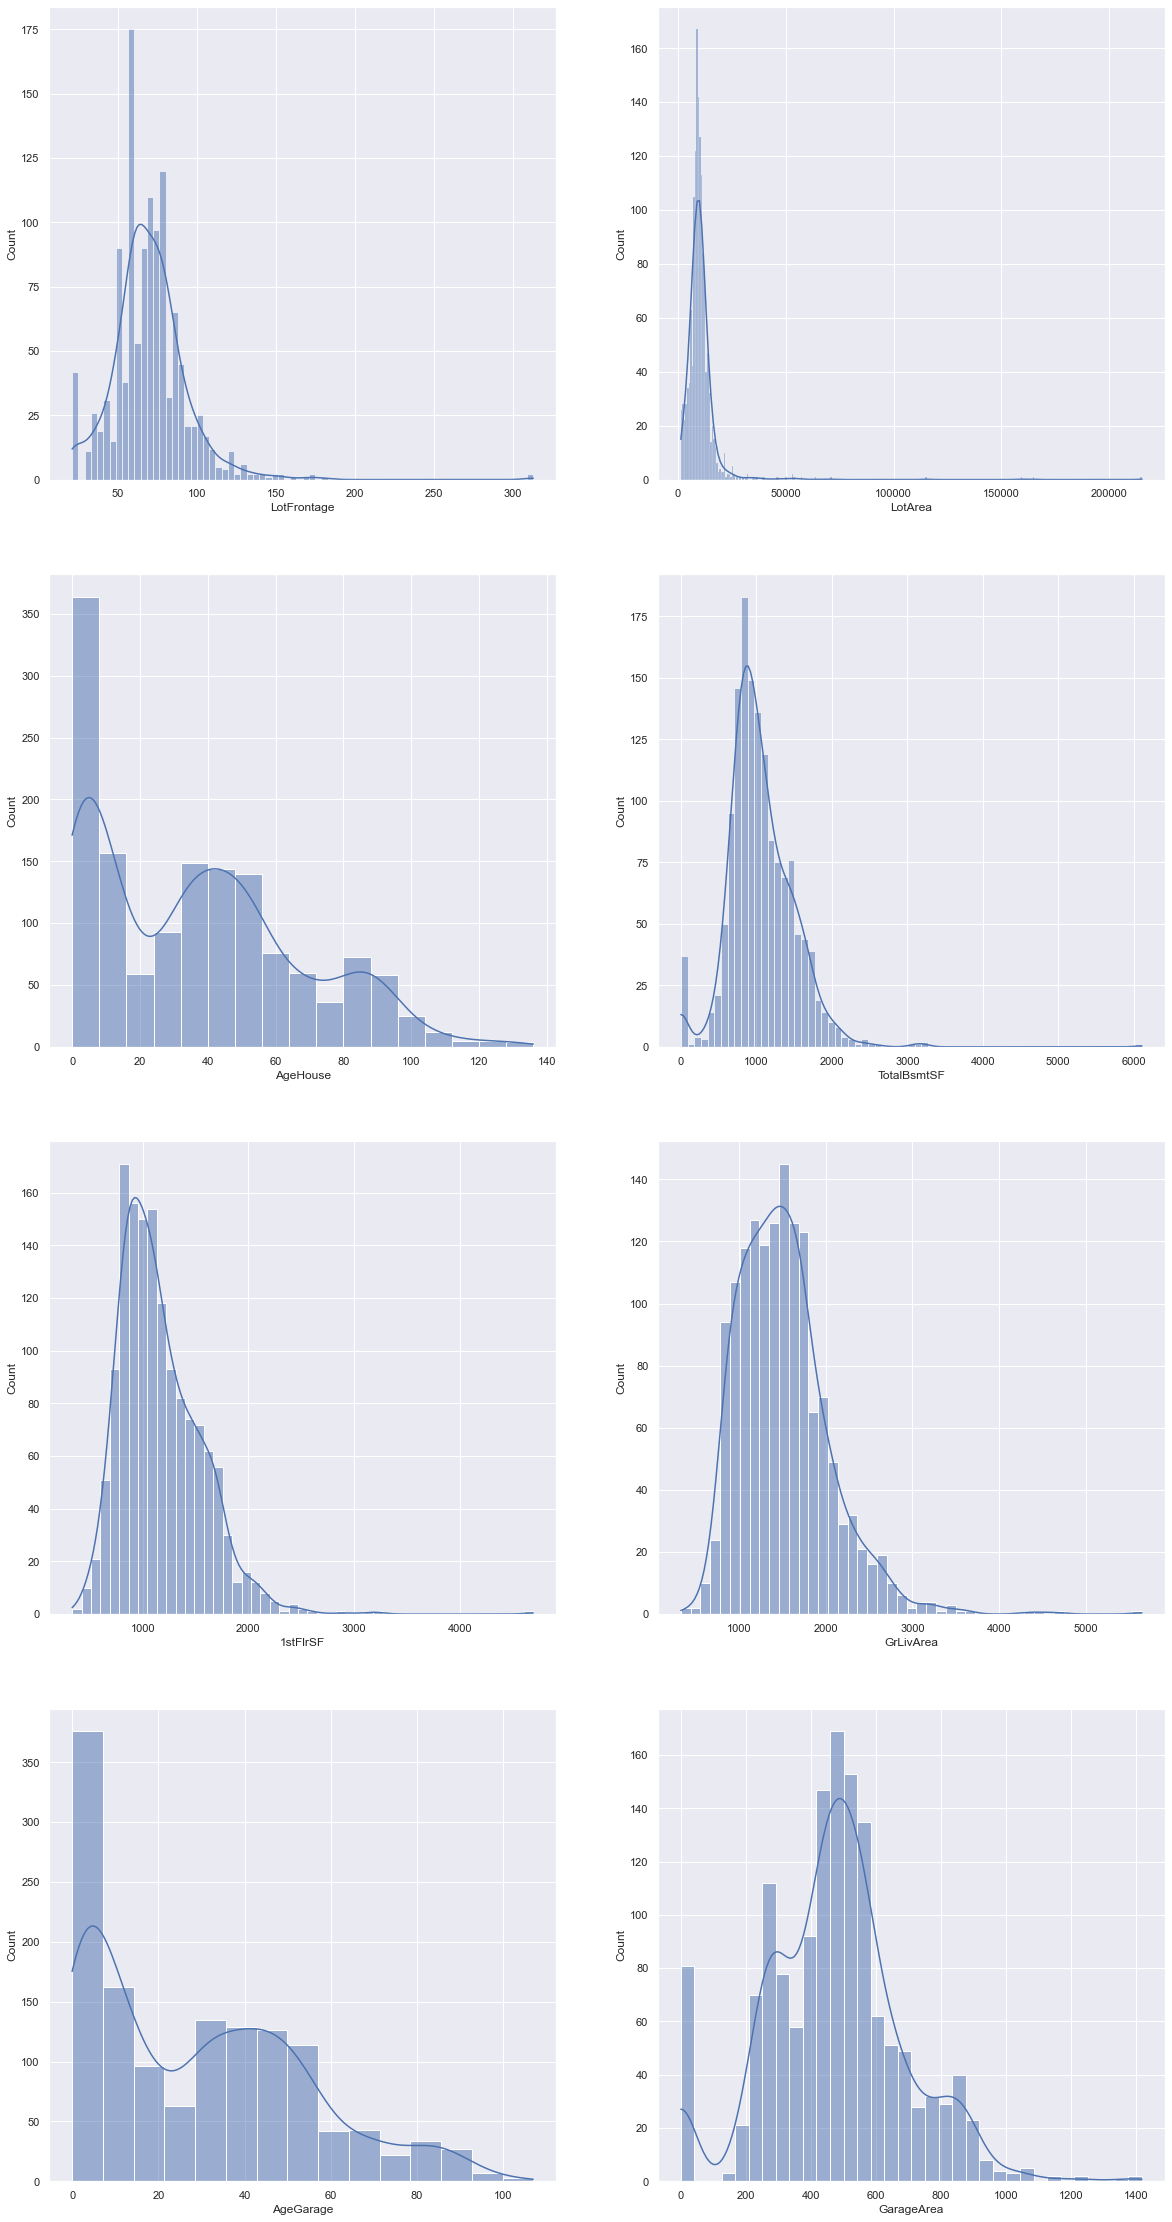

In [27]:
draw_histplots(df_train, continuous_features, kde=True)

#### Boxplots

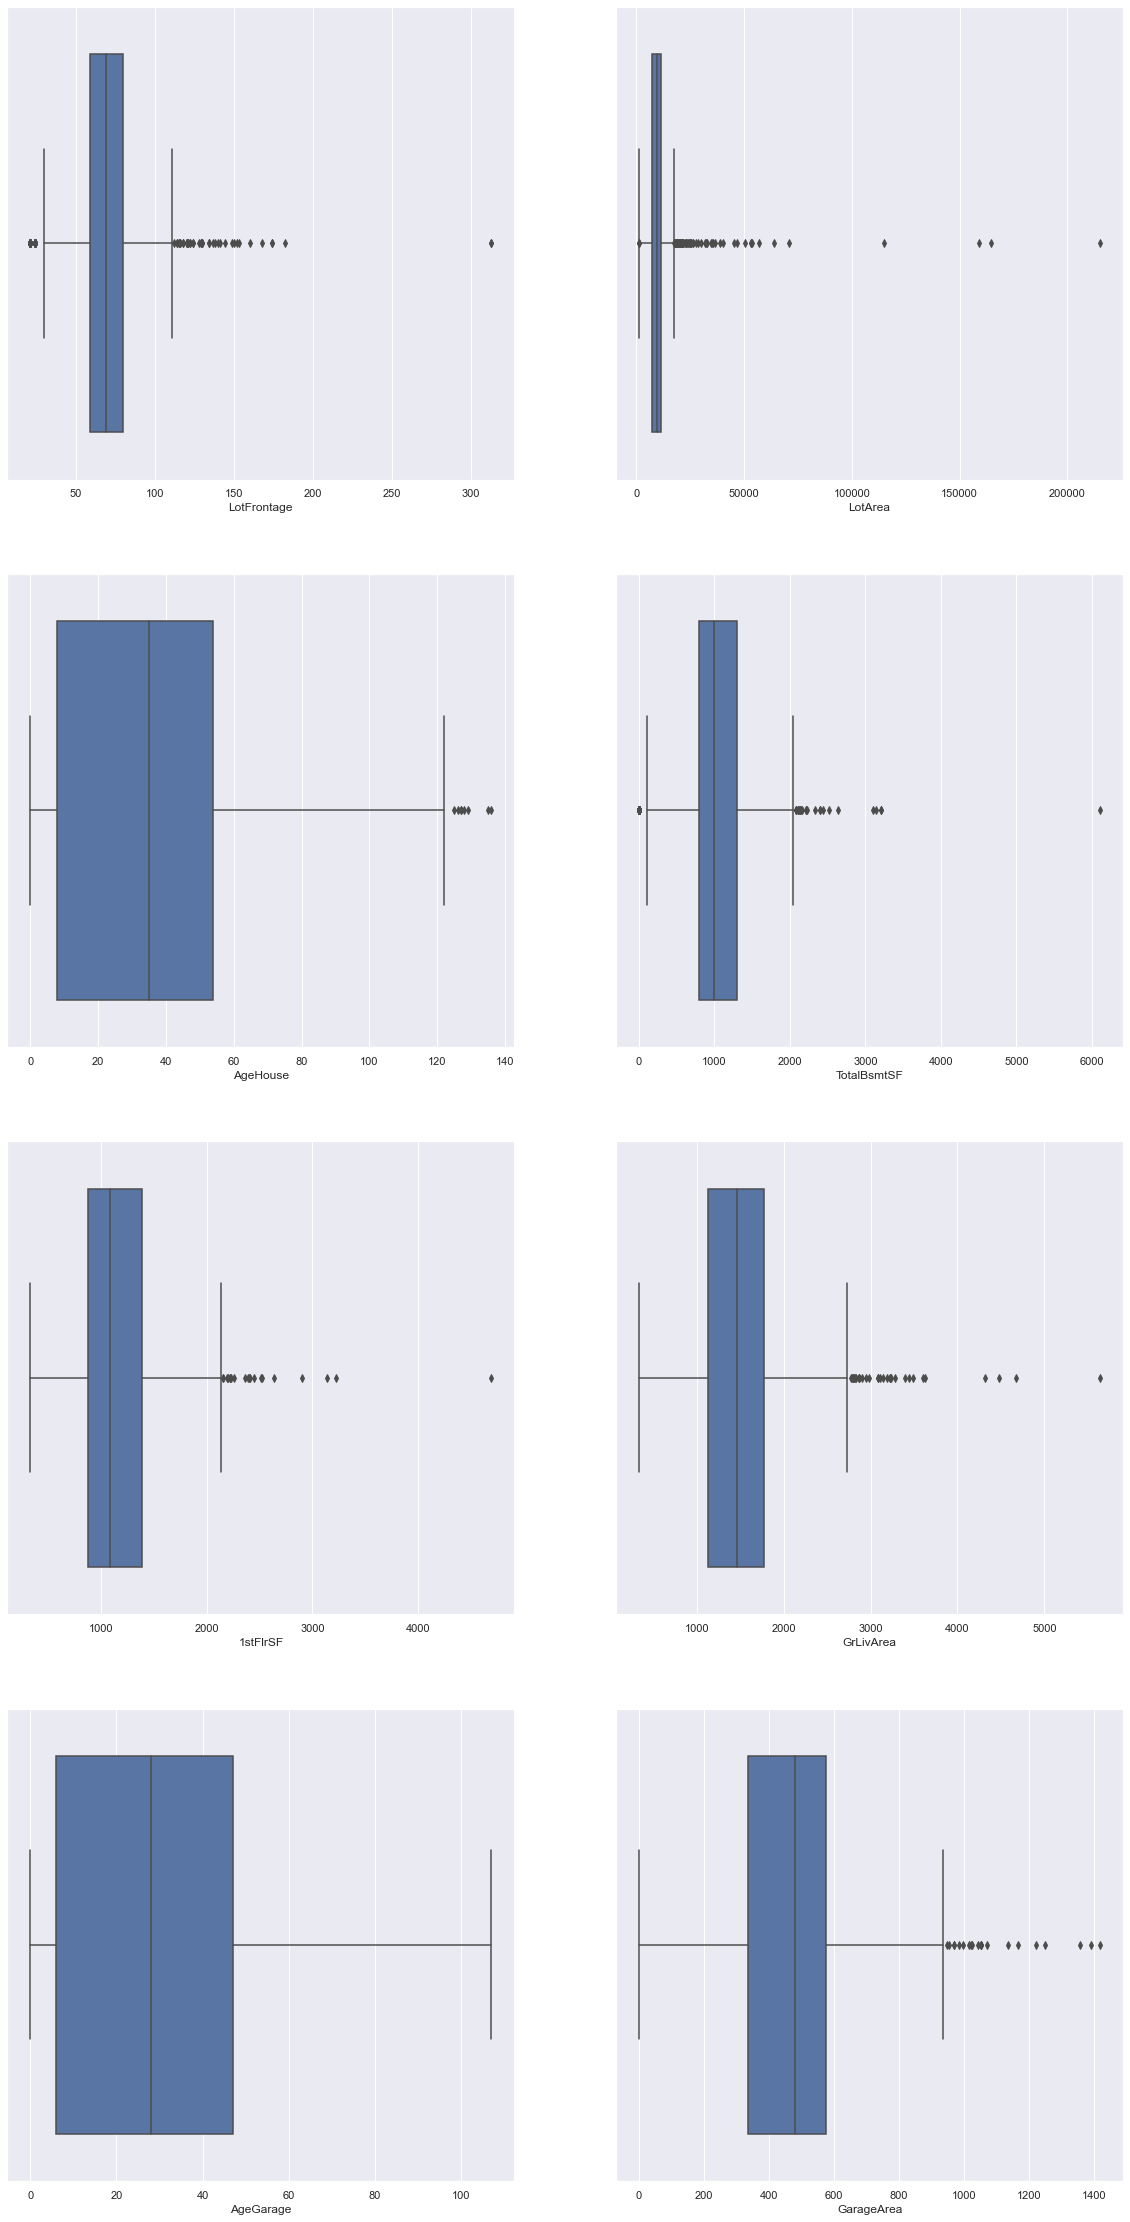

In [28]:
draw_boxplots(df_train, continuous_features)

#### Normality tests

In [29]:
tests_normal(df_train, continuous_features)

stats_pearson  p_value_pearson  \
LotFrontage            NaN              NaN   
LotArea        2590.591868     0.000000e+00   
AgeHouse         97.029219     8.518691e-22   
TotalBsmtSF     622.895104    5.496002e-136   
1stFlrSF        461.006742    7.828130e-101   
GrLivArea       437.120257     1.203767e-95   
AgeGarage              NaN              NaN   
GarageArea       34.041382     4.055158e-08   

                                       conclusion_pearson  
LotFrontage  The distribution isn't a normal distribution  
LotArea      The distribution isn't a normal distribution  
AgeHouse     The distribution isn't a normal distribution  
TotalBsmtSF  The distribution isn't a normal distribution  
1stFlrSF     The distribution isn't a normal distribution  
GrLivArea    The distribution isn't a normal distribution  
AgeGarage    The distribution isn't a normal distribution  
GarageArea   The distribution isn't a normal distribution

##### Conclusion:
Continuous variables do not have a normal distribution, these vari ables have a differential distribution. The StandardScaler transformation will be applied, missing data will be filled with the median due to the asymmetry of the distributions.  

### Analysis of the relationship between the objective variable and continuous variables

#### Matrix of absolute values of Pearson's linear correlation coefficients

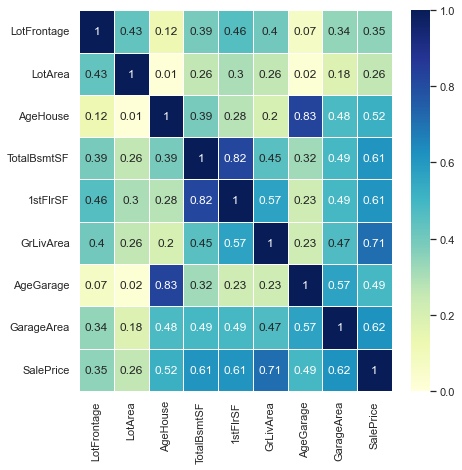

In [30]:
plt.figure(figsize = (7,7))
sns.heatmap(round(np.abs(df_train[continuous_features+['SalePrice']].corr()),2),  
            cmap="YlGnBu", linecolor="white", linewidth=0.5, vmin= 0, vmax= 1, annot=True );

#### A graph of the relationship between numeric variables and the target variable

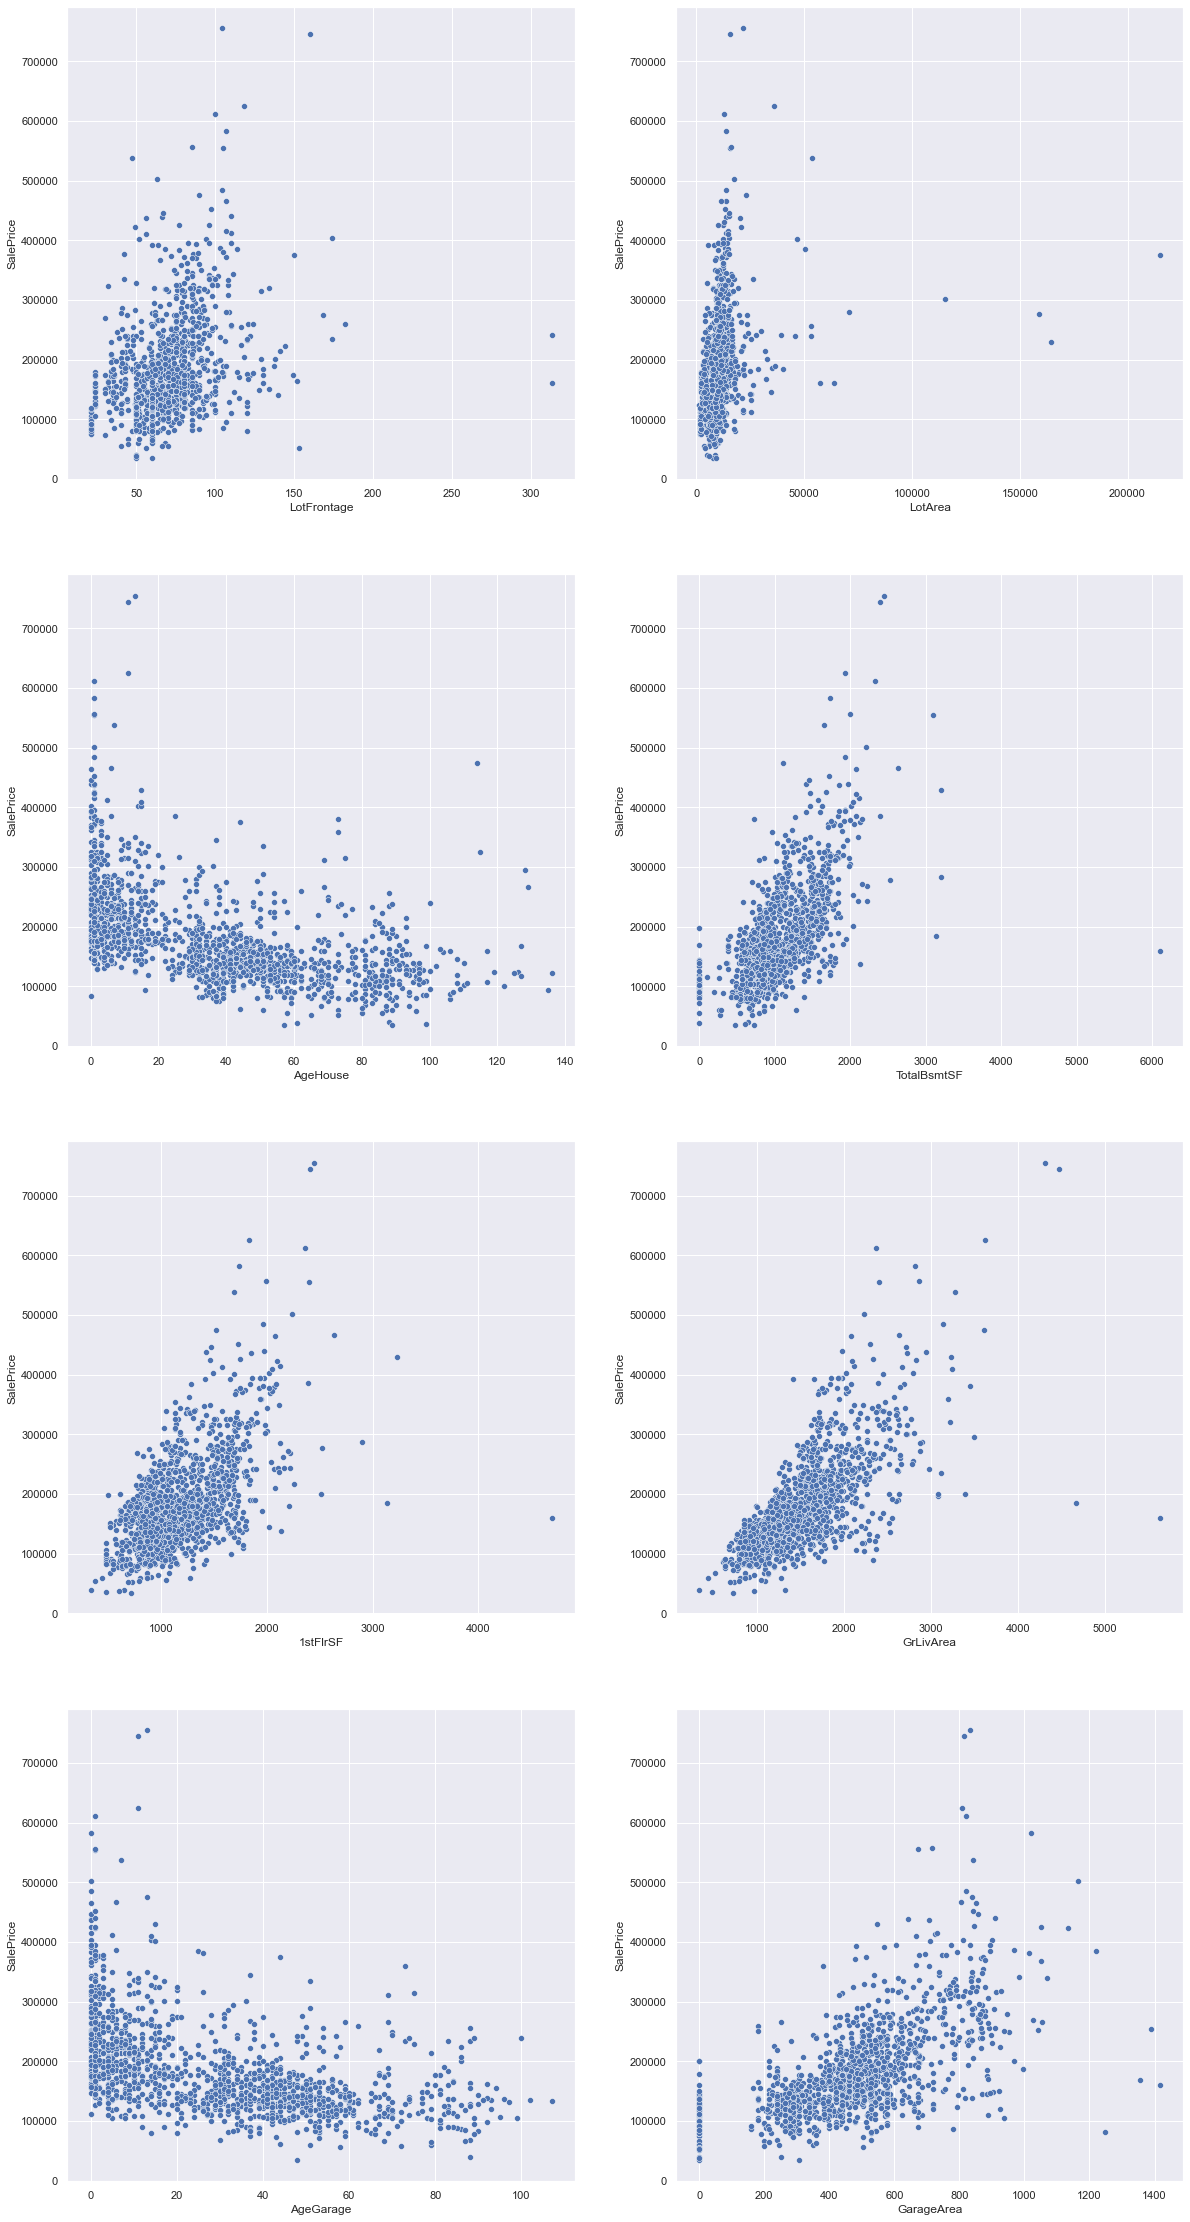

In [31]:
draw_scatterplots(df_train[continuous_features+['SalePrice']], continuous_features, y='SalePrice')

#### Conclusion:
All continuous numeric variables affect the target variable. The area of the apartment above the ground (GrLivArea) has the strongest influence on the price of real estate. There is a strong relationship between the age of the property and the age of the garage (which is justified, because probably in most cases the garage was built at the same time as the property) and between the area of the first floor and the area of the basement. We remove the AgeGarage and TotalBsmtSF variables because they have lower correlation coefficients with the target variable.

### Analysis of discrete numerical variables

#### Descriptive statistics

In [32]:
df_train[discrete_features].describe()

FullBath     HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  \
count  1460.000000  1460.000000   1460.000000   1460.000000   1460.000000   
mean      1.565068     0.382877      2.866438      1.046575      6.517808   
std       0.550916     0.502885      0.815778      0.220338      1.625393   
min       0.000000     0.000000      0.000000      0.000000      2.000000   
25%       1.000000     0.000000      2.000000      1.000000      5.000000   
50%       2.000000     0.000000      3.000000      1.000000      6.000000   
75%       2.000000     1.000000      3.000000      1.000000      7.000000   
max       3.000000     2.000000      8.000000      3.000000     14.000000   

        Fireplaces   GarageCars       YrSold  
count  1460.000000  1460.000000  1460.000000  
mean      0.613014     1.767123  2007.815753  
std       0.644666     0.747315     1.328095  
min       0.000000     0.000000  2006.000000  
25%       0.000000     1.000000  2007.000000  
50%       1.000000     2.000000  2008.000000  
75%       1.000000     2.000000  2009.000000  
max       3.000000     4.000000  2010.000000

#### Histograms

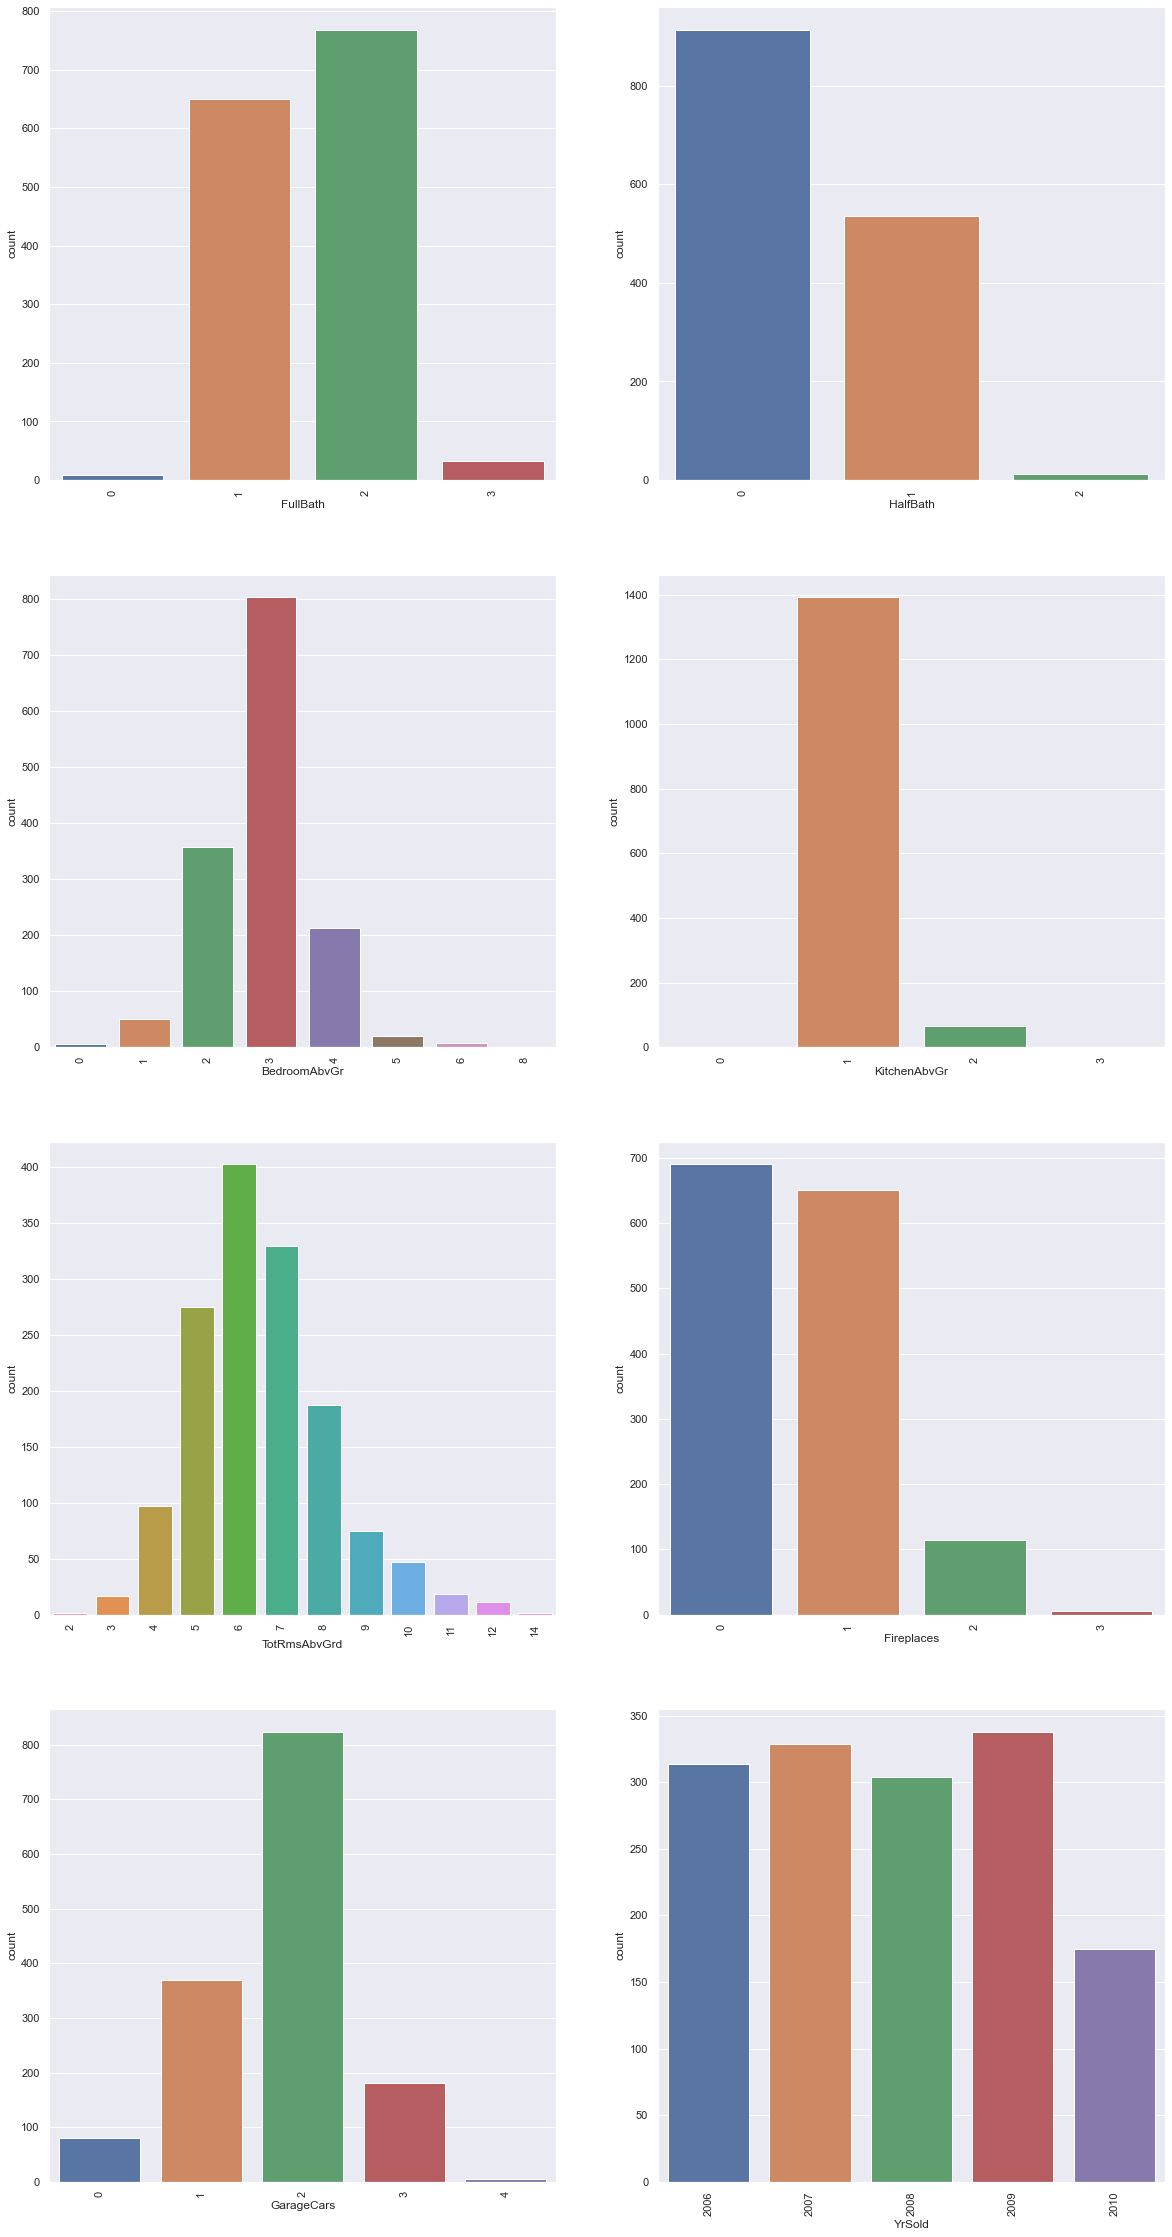

In [33]:
draw_countplots(df_train, discrete_features)

#### Boxplots

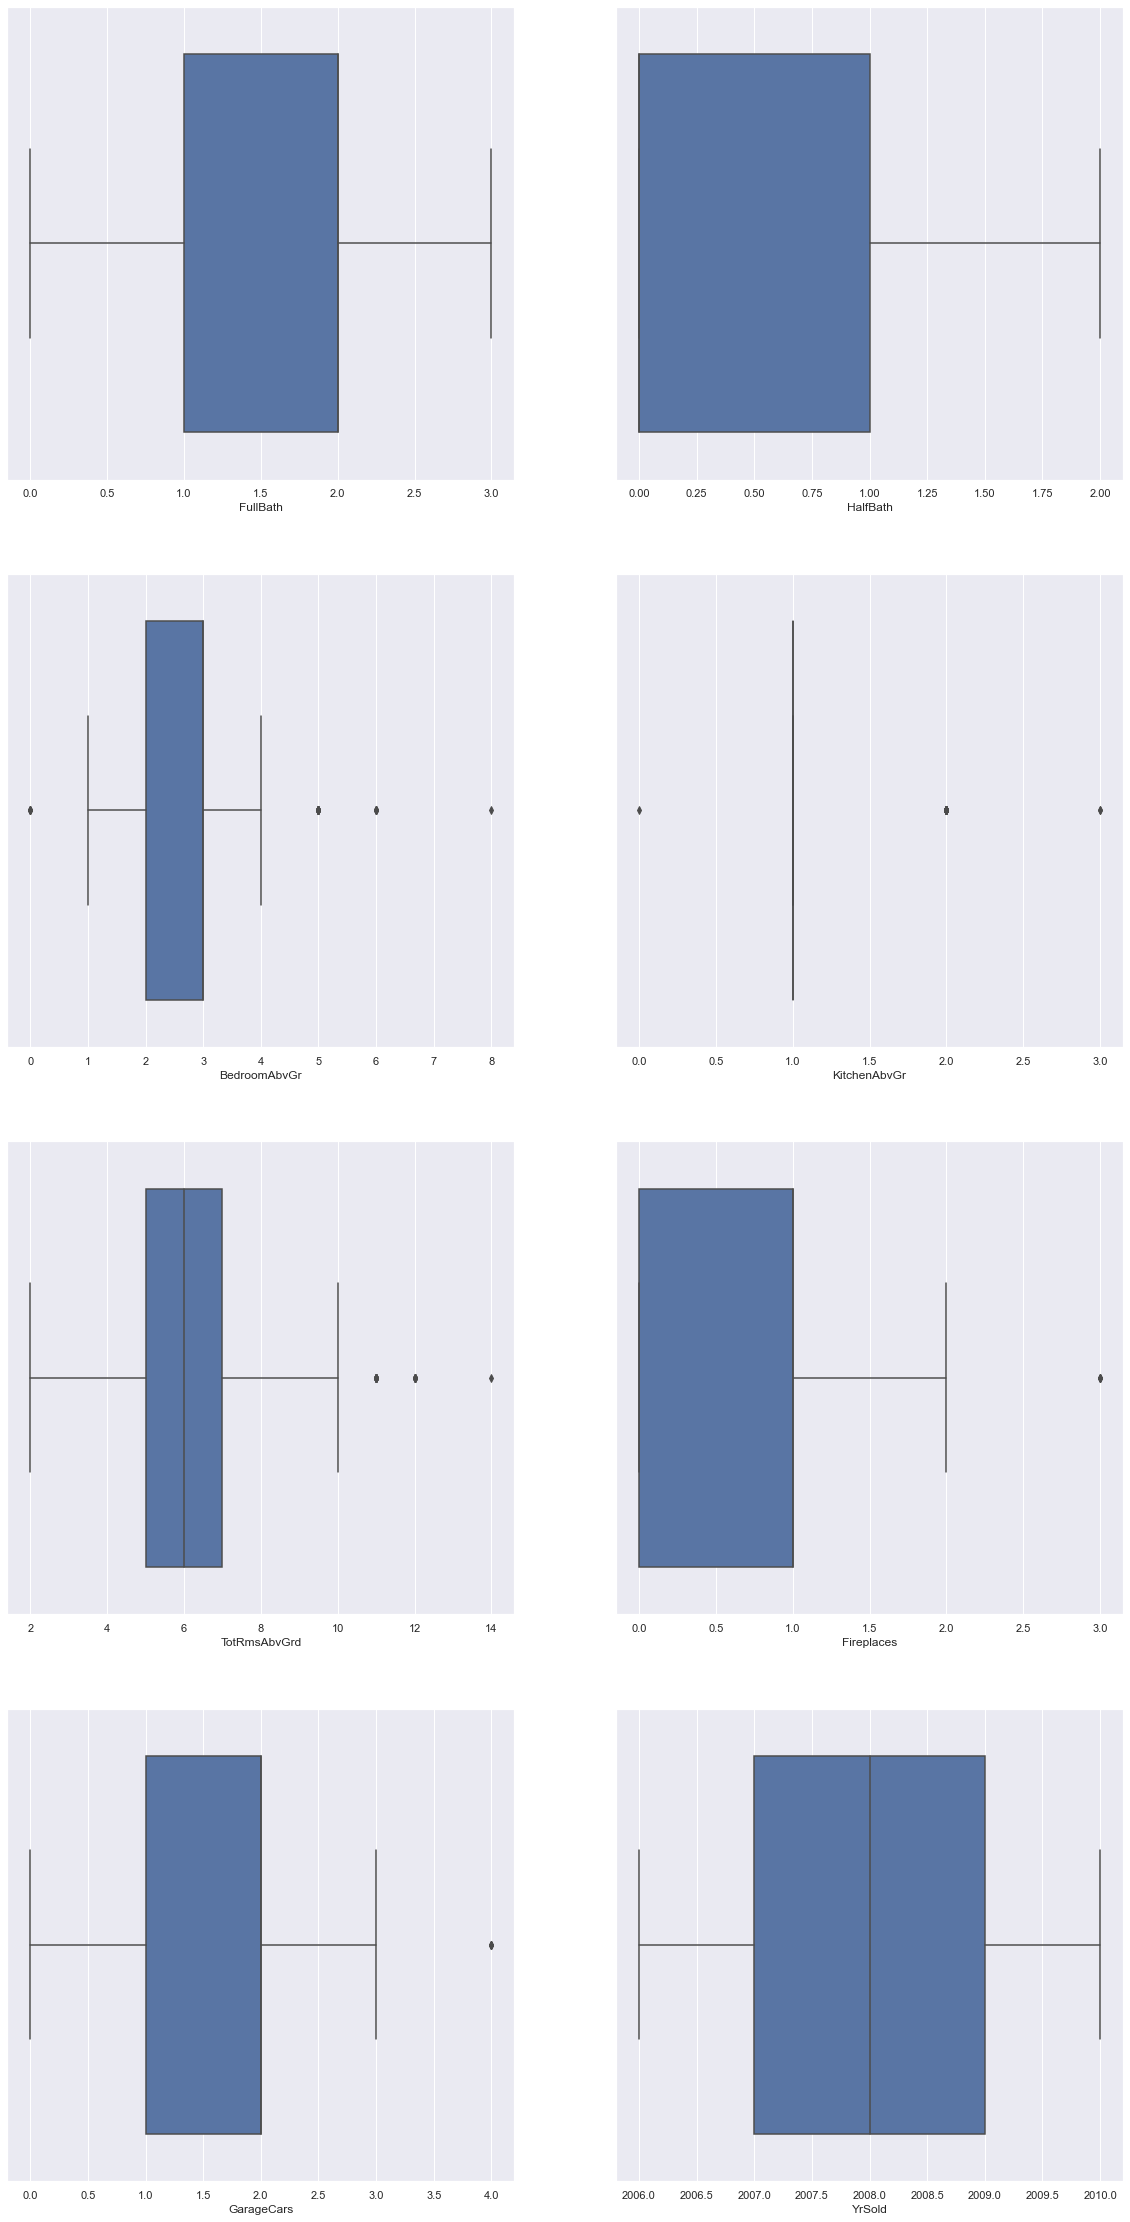

In [34]:
draw_boxplots(df_train, discrete_features)

#### Normality test

In [35]:
tests_normal(df_train, discrete_features)

stats_pearson  p_value_pearson  \
FullBath         158.542704     3.740153e-35   
HalfBath         581.831120    4.539182e-127   
BedroomAbvGr      90.289655     2.476569e-20   
KitchenAbvGr    1339.254357    1.529718e-291   
TotRmsAbvGrd     118.138505     2.221005e-26   
Fireplaces        90.609578     2.110475e-20   
GarageCars        29.925270     3.175486e-07   
YrSold          1051.835954    3.951160e-229   

                                        conclusion_pearson  
FullBath      The distribution isn't a normal distribution  
HalfBath      The distribution isn't a normal distribution  
BedroomAbvGr  The distribution isn't a normal distribution  
KitchenAbvGr  The distribution isn't a normal distribution  
TotRmsAbvGrd  The distribution isn't a normal distribution  
Fireplaces    The distribution isn't a normal distribution  
GarageCars    The distribution isn't a normal distribution  
YrSold        The distribution isn't a normal distribution

##### Conclusion:
Discrete variables do not have a normal distribution, although the graphical interpretation shows that some of the variables have a shape distribution close to the normal distribution. The YrSold variable does not bear anything to analyze, the distribution is almost uniform (except for 2010), the age of the property has already been taken into account, so YrSold can be omitted in further analyses. The StandardScaler will be applied and missing values filled with the median.

### Analysis of the relationship between the objective variable and discrete numerical variables

#### Matrix of absolute values of Pearson's linear correlation coefficients

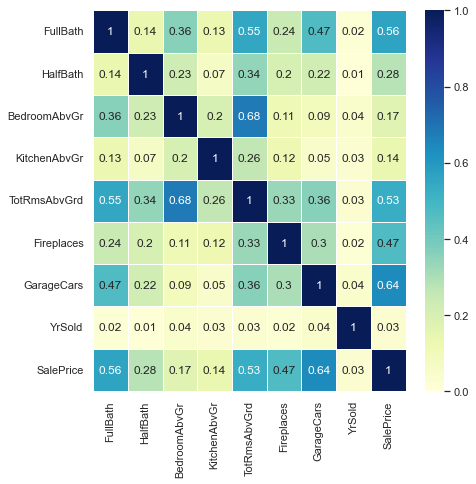

In [36]:
plt.figure(figsize = (7,7))
sns.heatmap(round(np.abs(df_train[discrete_features+['SalePrice']].corr()),2),  
            cmap="YlGnBu", linecolor="white", linewidth=0.5, vmin= 0, vmax= 1, annot=True );

#### A graph of the relationship between discrete numeric variables and the target variable

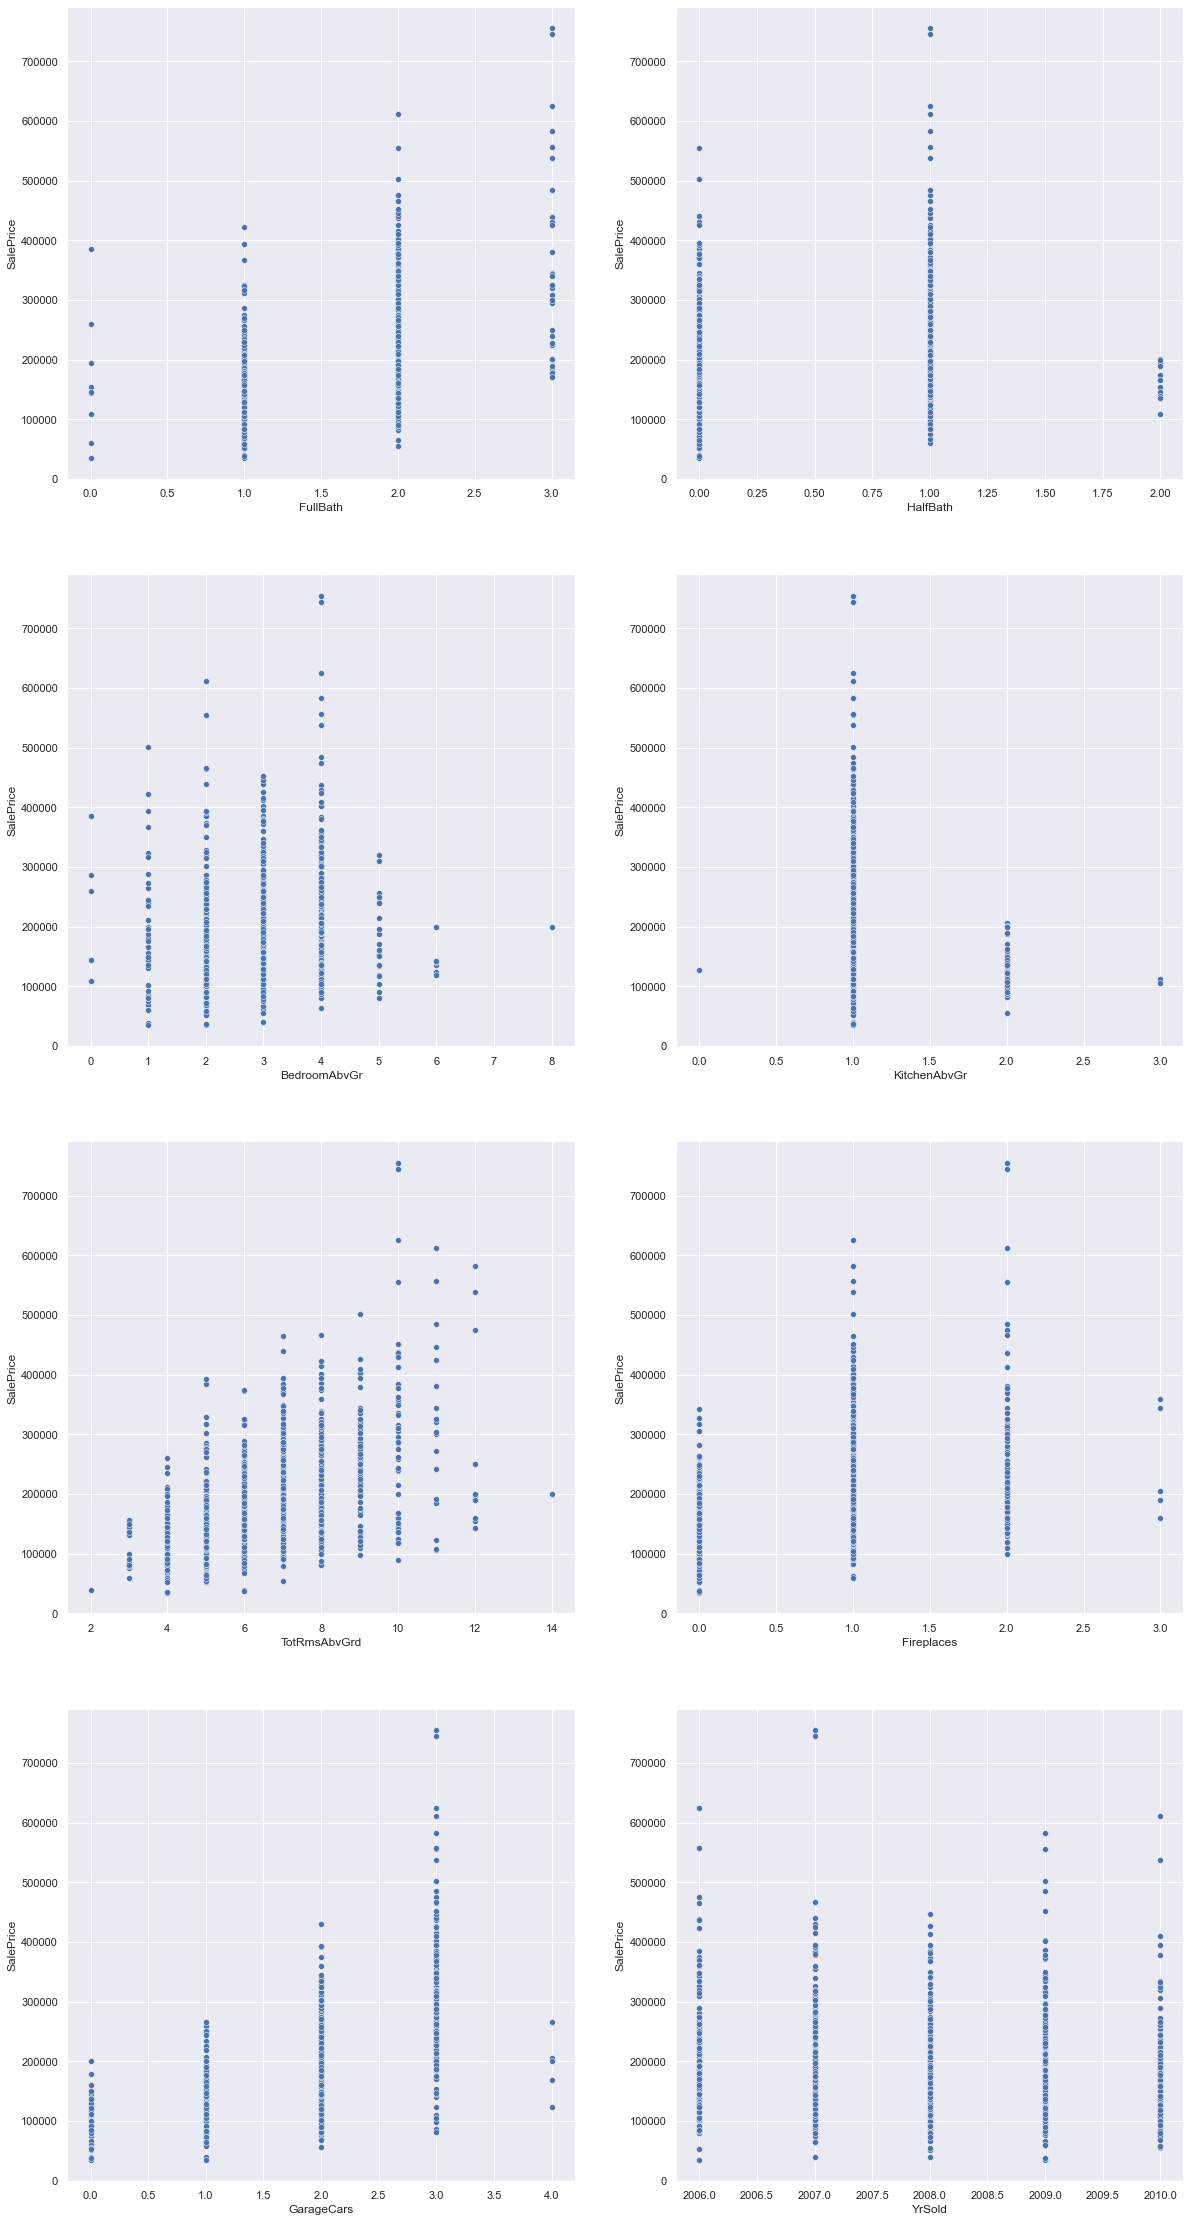

In [37]:
draw_scatterplots(df_train, discrete_features, y='SalePrice')

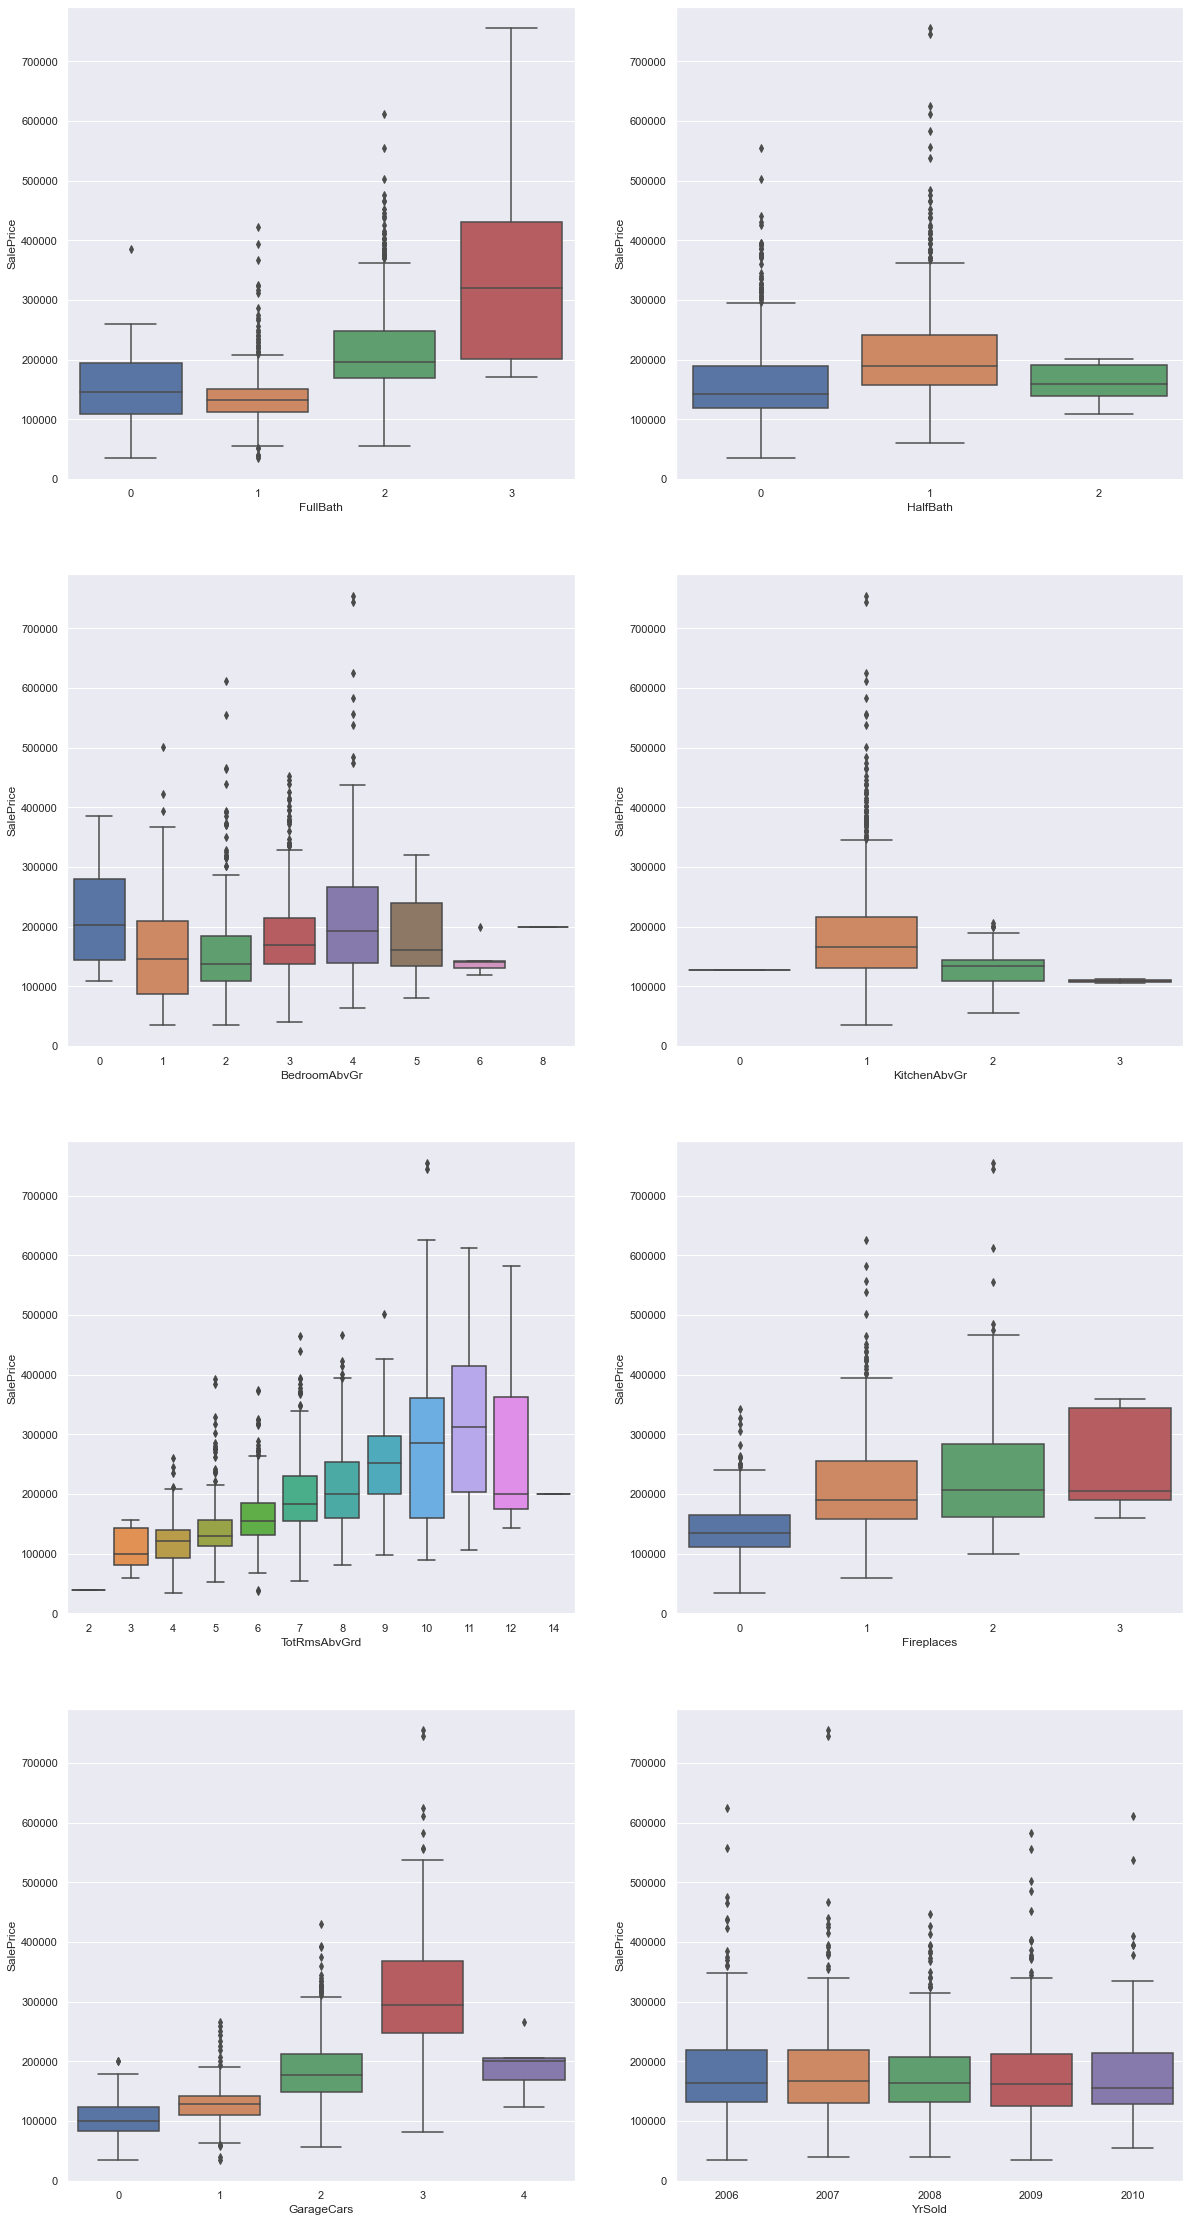

In [38]:
draw_boxplots(df_train, discrete_features, y='SalePrice')

#### Conclusion:
There is a relationship between almost all discrete numeric variables and the target variable, with the exception of year of sale, which is completely removed from the analysis. The relationship is particularly visible in the boxplots for 'FullBath', 'TotRmsAbvGrd', 'Fireplaces' and 'GarageCars'. The relationship between 'TotRmsAbvGr' and 'BedroomAbvGr' is strong, so we can omit the room number variable.

### Analysis for ordinal variables

#### Descriptive statistics

In [39]:
df_train[ordinal_features].describe(include='all')

Overall        Exter         Bsmt    HeatingQC  KitchenQual  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean      5.837329     2.239726     1.684700     3.145205     2.511644   
std       0.846764     0.337913     0.656121     0.959501     0.663760   
min       1.000000     1.000000    -1.000000     0.000000     1.000000   
25%       5.500000     2.000000     1.333300     2.000000     2.000000   
50%       6.000000     2.000000     1.666700     4.000000     2.000000   
75%       6.500000     2.500000     2.000000     4.000000     3.000000   
max       9.500000     4.000000     3.333300     4.000000     4.000000   

       FireplaceQu  GarageFinish       Garage  
count  1460.000000   1460.000000  1460.000000  
mean      0.825342      0.715753     1.872603  
std       1.810877      0.892831     0.482244  
min      -1.000000     -1.000000    -1.000000  
25%      -1.000000      0.000000     2.000000  
50%       1.000000      1.000000     2.000000  
75%       3.000000      1.000000     2.000000  
max       4.000000      2.000000     3.000000

#### Countplots

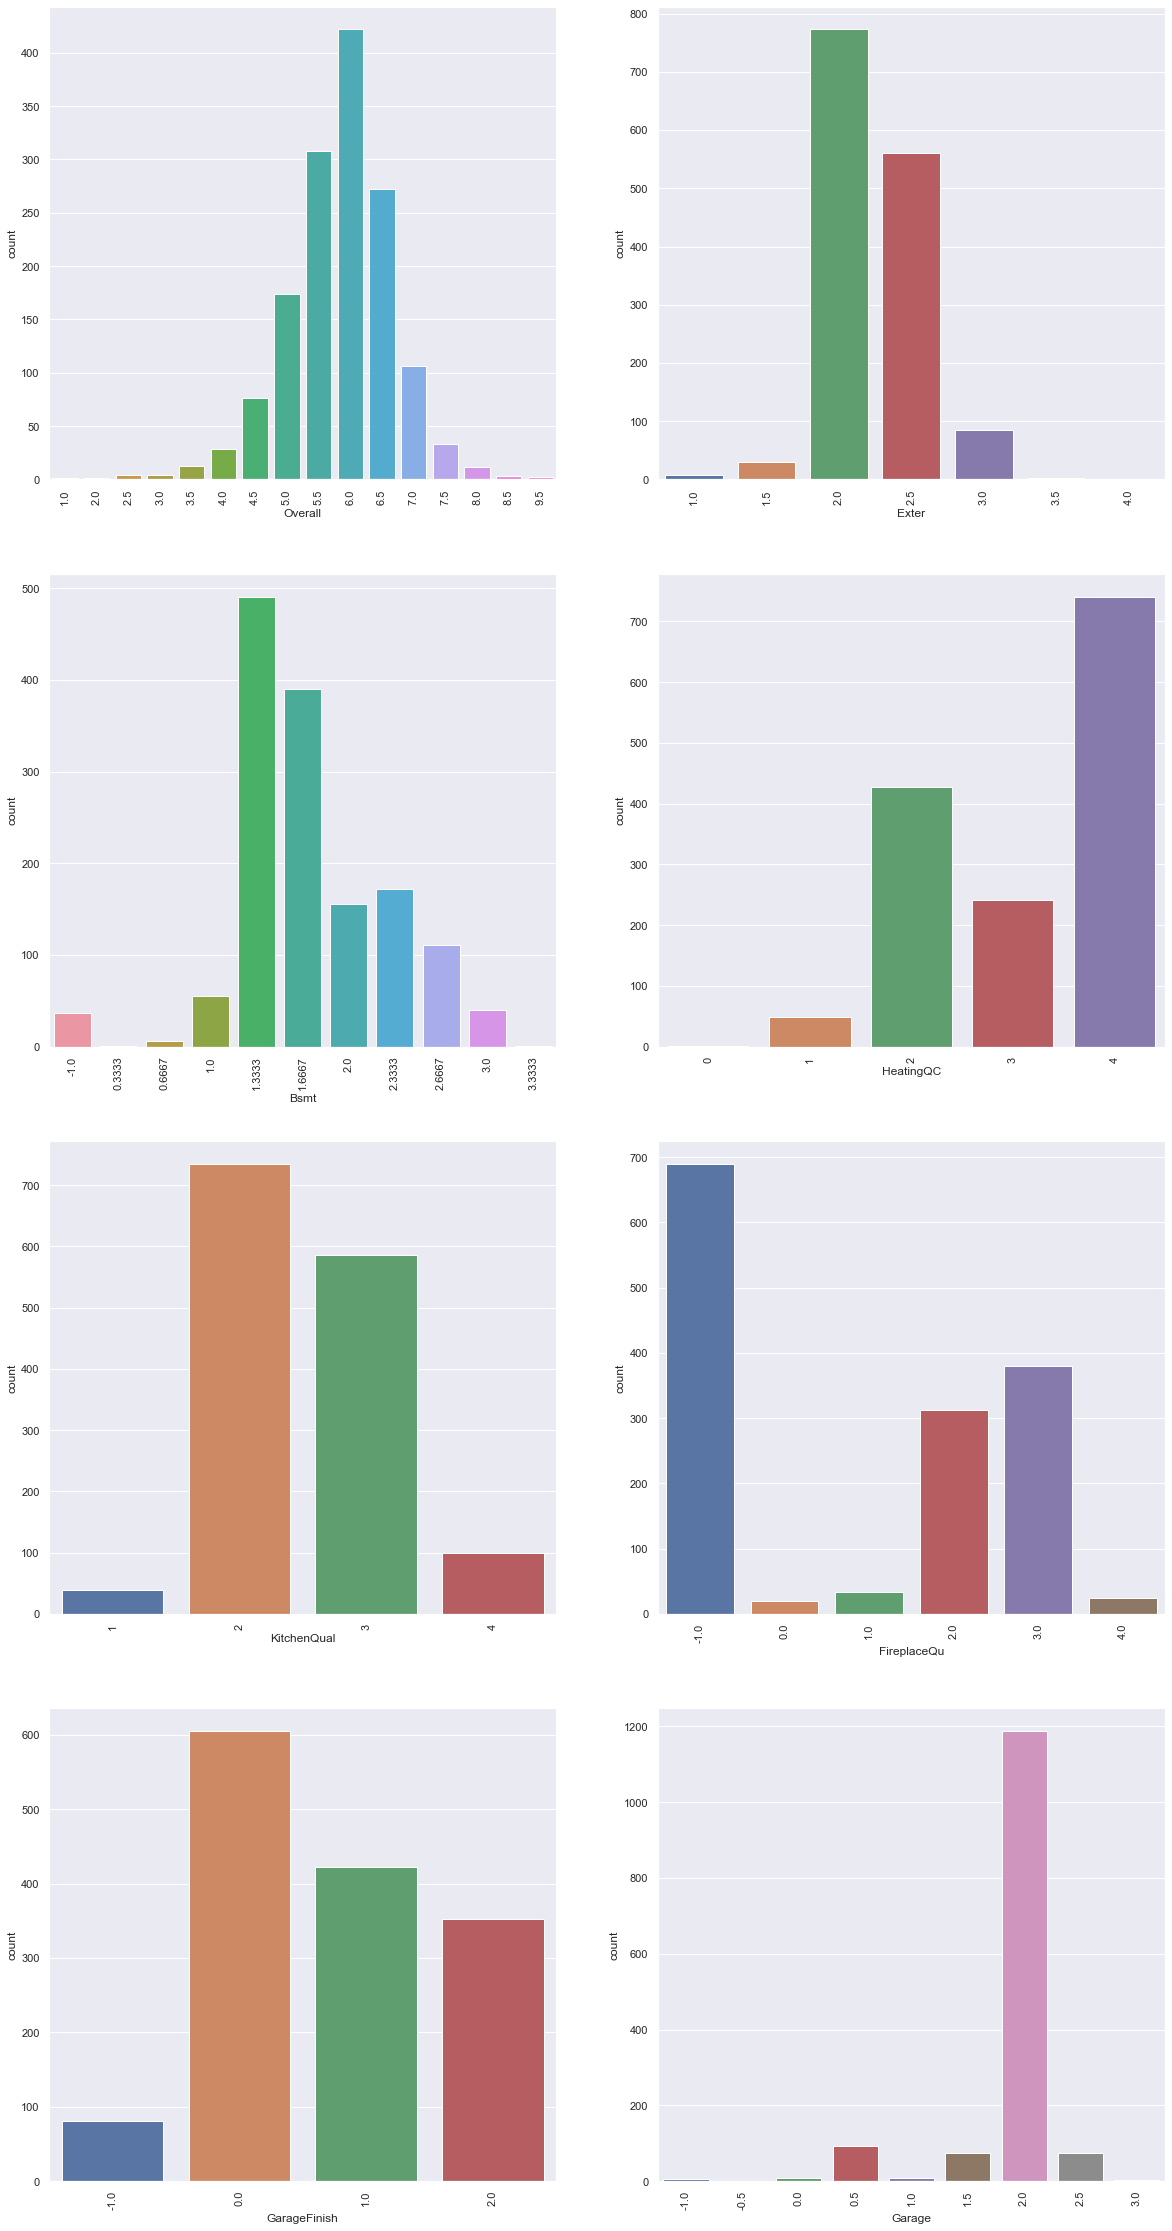

In [40]:
draw_countplots(df_train, ordinal_features)

#### Boxplots

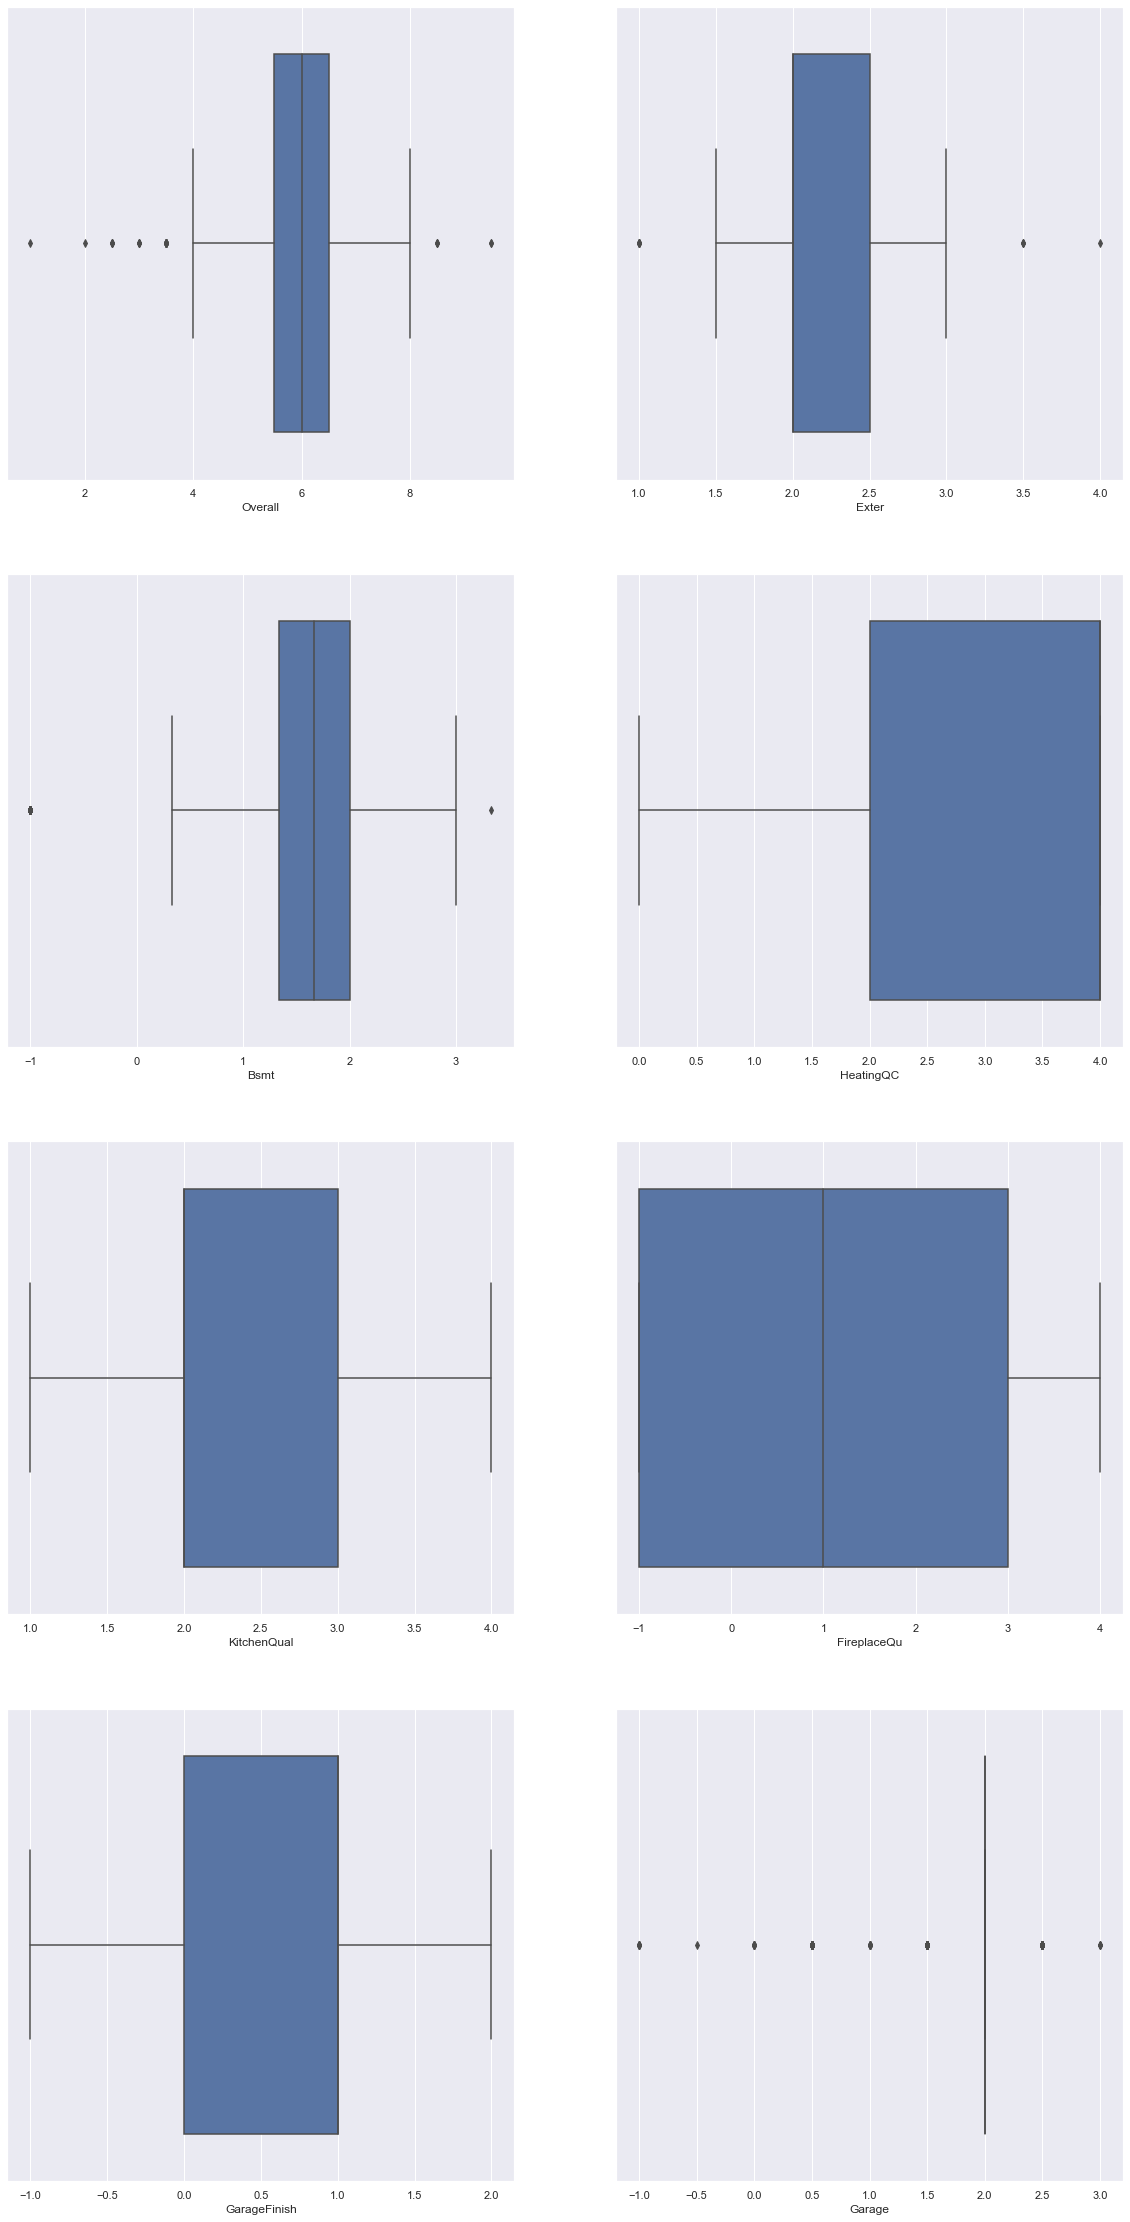

In [41]:
draw_boxplots(df_train, ordinal_features)

#### Conclusion:
Ordinal variables have a very diversified shape of distributions, the most similar shape to the normal distribution is the shape of the distribution for the property evaluating variable (Overall). The StandardScaler will be applied and missing values filled with the median.

### Analysis of the relationship between the objective variable and ordinal variables

#### Matrix of absolute values of Spearman correlation coefficients

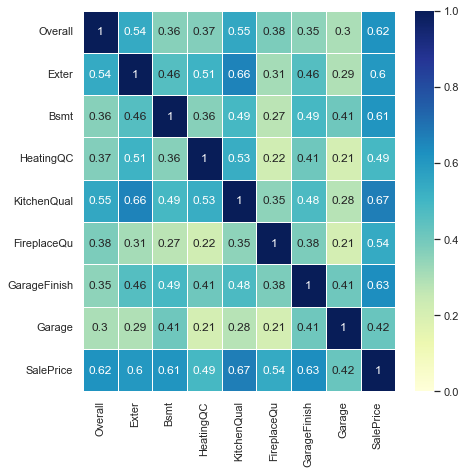

In [42]:
plt.figure(figsize = (7,7))
sns.heatmap(round(np.abs(df_train[ordinal_features+['SalePrice']].corr(method='spearman')),2),  
            cmap="YlGnBu", linecolor="white", linewidth=0.5, vmin= 0, vmax= 1, annot=True );

#### Graph of the relationship between the ordinal variables and the target variable

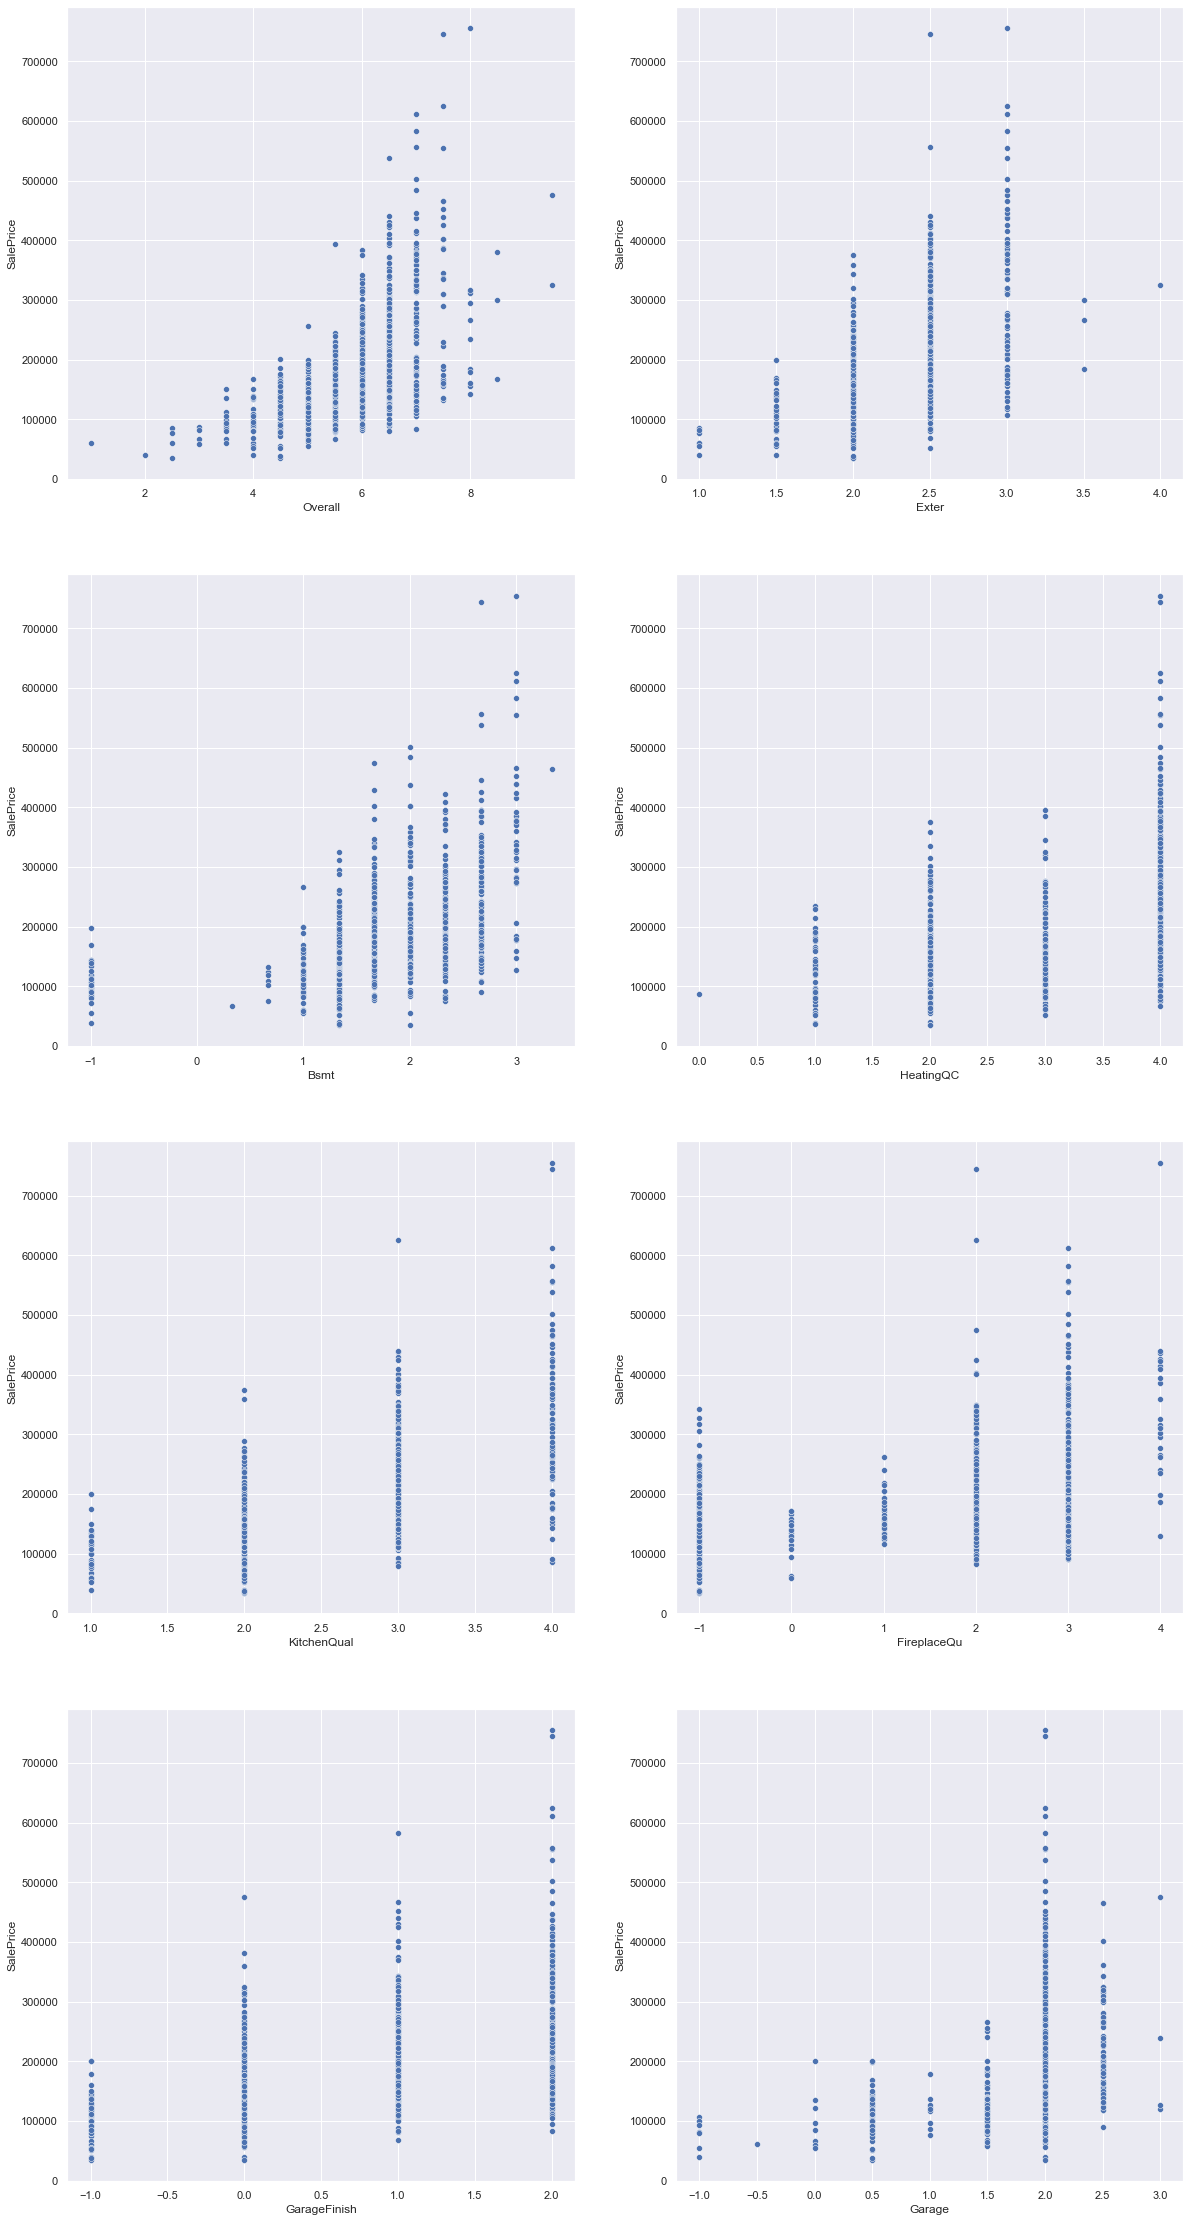

In [43]:
draw_scatterplots(df_train, ordinal_features, y='SalePrice')

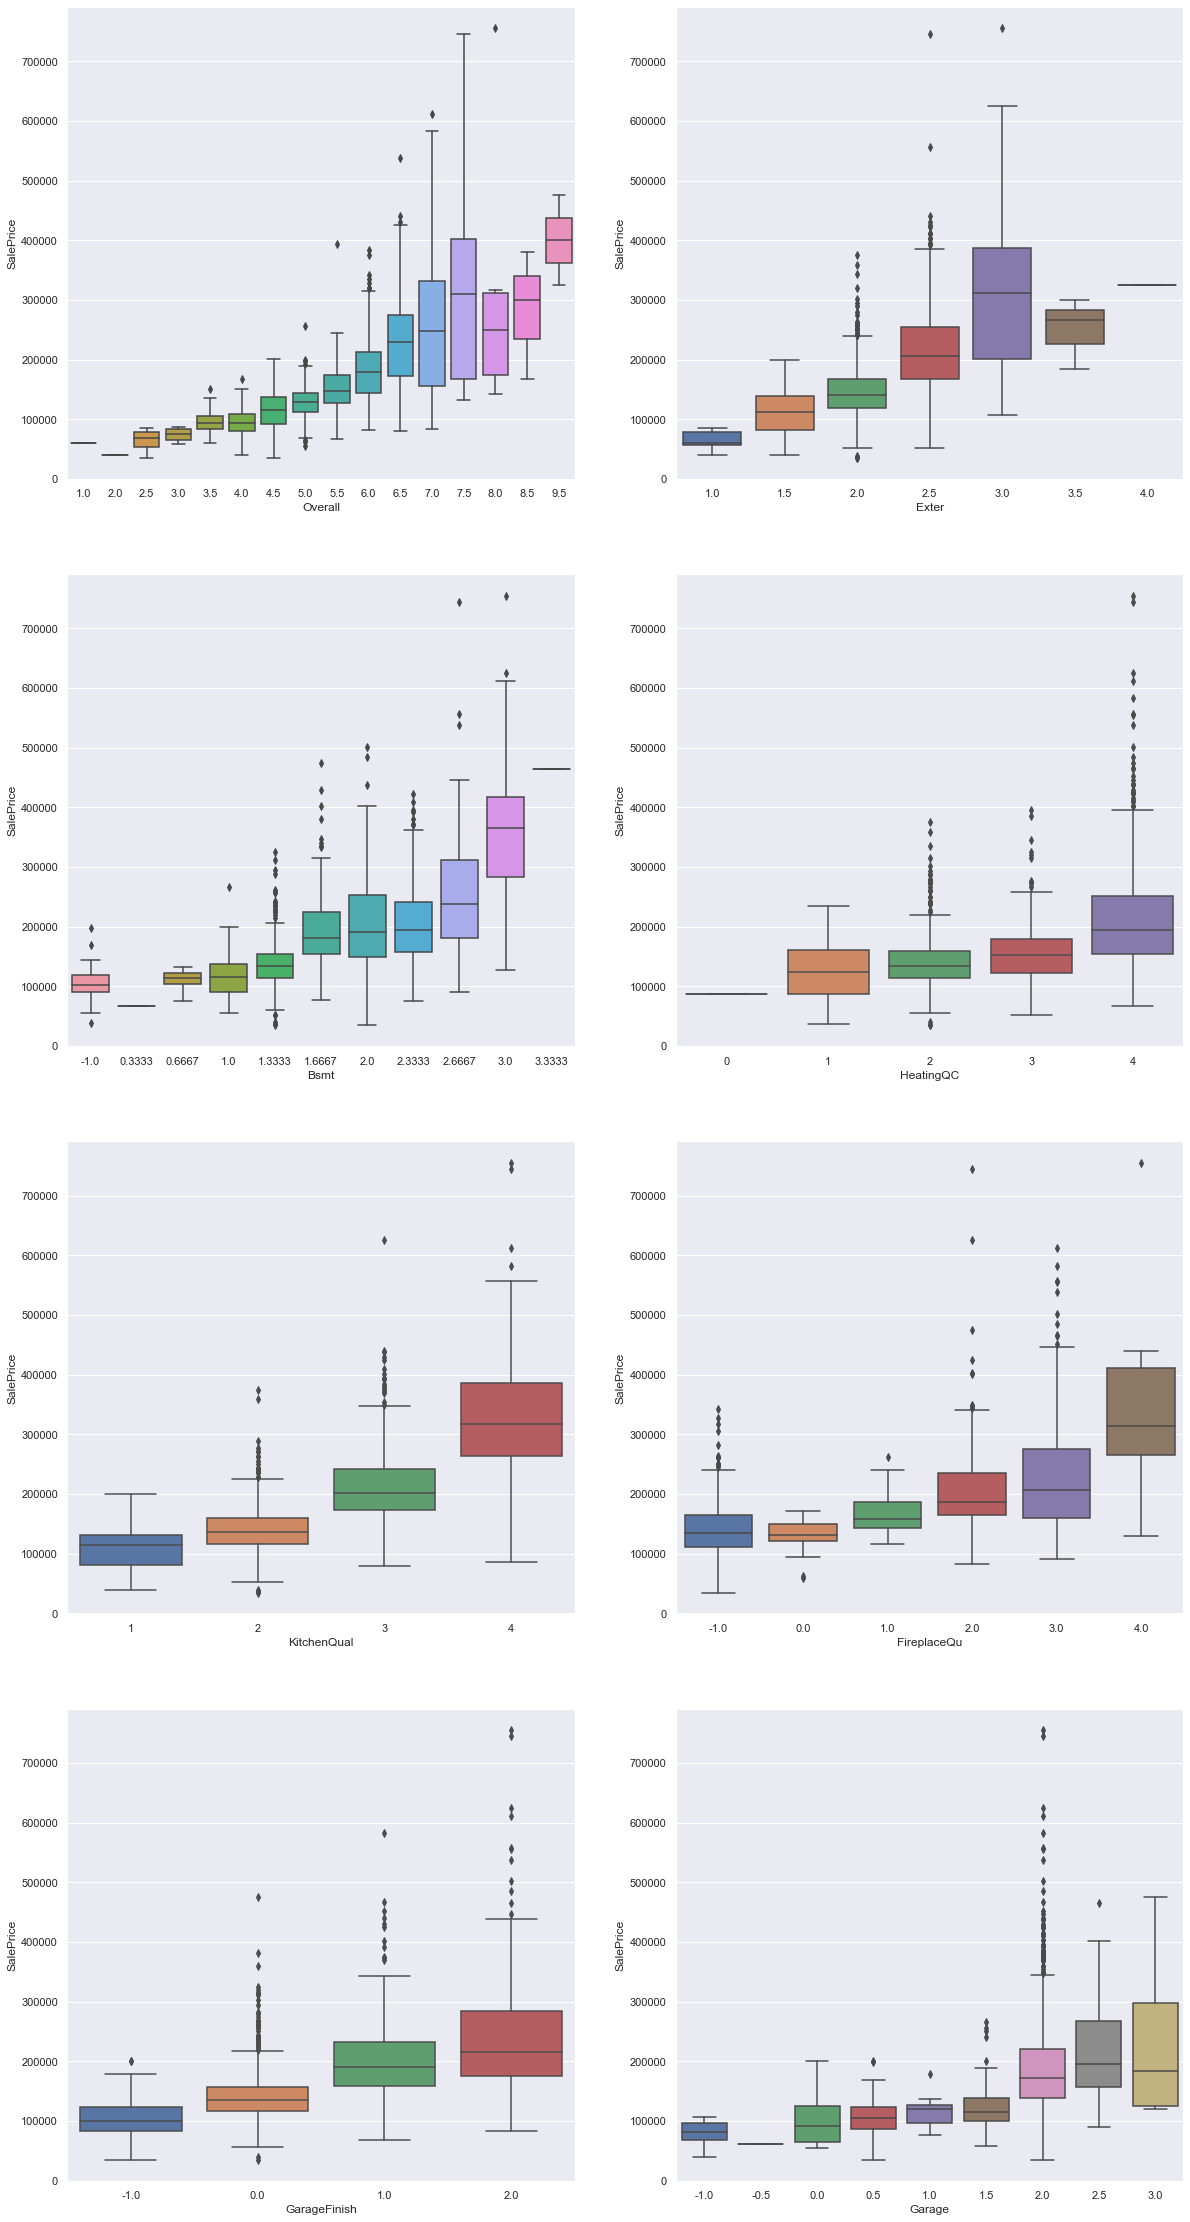

In [44]:
draw_boxplots(df_train, ordinal_features, y='SalePrice')

#### Conclusion:
All ordinal variables affect the target variable 'SalePrice'. The variables that influence each other the most are Exter (assessment of materials outside the property) and KitchenQual (assessment of the quality of the kitchen), but they are variables that logically should not influence each other, so I will leave both in the model.

### Analysis for categorical variables

#### Descriptive statistics

In [46]:
df_train[categorical_features].describe(include='all').T

count unique      top  freq
MSSubClass       1460     15       20   536
MSZoning         1460      5       RL  1151
Street           1460      2     Pave  1454
AlleyYN          1460      2       No  1369
LotShape         1460      4      Reg   925
LandContour      1460      4      Lvl  1311
Utilities        1460      2   AllPub  1459
LotConfig        1460      5   Inside  1052
LandSlope        1460      3      Gtl  1382
Neighborhood     1460     25    NAmes   225
BldgType         1460      5     1Fam  1220
HouseStyle       1460      8   1Story   726
RoofStyle        1460      6    Gable  1141
RoofMatl         1460      8  CompShg  1434
MasVnrType       1452      4     None   864
Foundation       1460      6    PConc   647
Heating          1460      6     GasA  1428
CentralAir       1460      2        Y  1365
Electrical       1459      5    SBrkr  1334
Functional       1460      7      Typ  1360
GarageType       1460      7   Attchd   870
PavedDrive       1460      3        Y  1340
SaleType         1460      9       WD  1267
SaleCondition    1460      6   Normal  1198
BasementYN       1460      2      Yes  1421
FireplaceYN      1460      2      Yes   770
GarageYN         1460      2      Yes  1379
PoolYN           1460      2       No  1453
FenceYN          1460      2       No  1179
ShedYN           1460      2       No  1411
Artery           1460      2       No  1412
Feedr            1460      2       No  1374
Norm             1460      2      Yes  1260
RRNn             1460      2       No  1453
RRAn             1460      2       No  1433
PosN             1460      2       No  1441
PosA             1460      2       No  1451
RRNe             1460      2       No  1458
RRAe             1460      2       No  1448
EnclosedPorchYN  1460      2       No  1252
3SsnPorchYN      1460      2       No  1436
ScreenPorchYN    1460      2       No  1344
OpenPorchSFYN    1460      2      Yes   804
2ndFlrYN         1460      2       No   829

#### Countplots

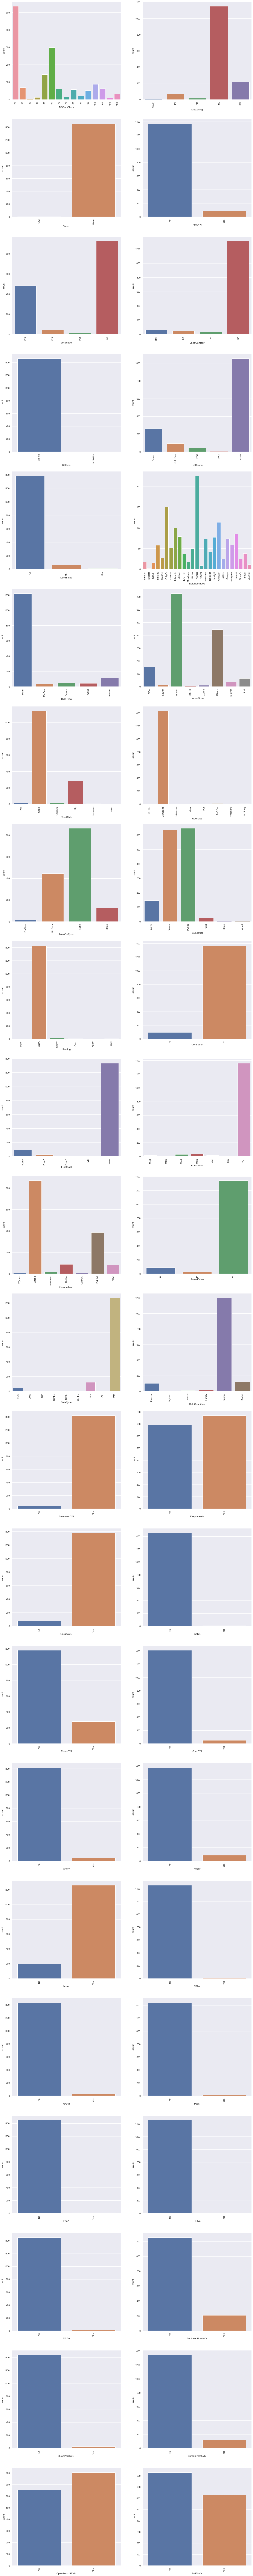

In [47]:
draw_countplots(df_train, categorical_features)

#### Conclusion:
Categorical variables have very varied graphs, for some variables one category of answers prevails, while for others these categories are distributed more evenly. The OneHotEncoder encoding method will be used and missing values will be replaced with the most common values.

### Analysis of the relationship between the objective variable and categorical variables

#### Correlation matrix Tschuprow's T-coefficient

In [48]:
T_czuprowa_table = correlaction_T_czuprowa(df_train, categorical_features)

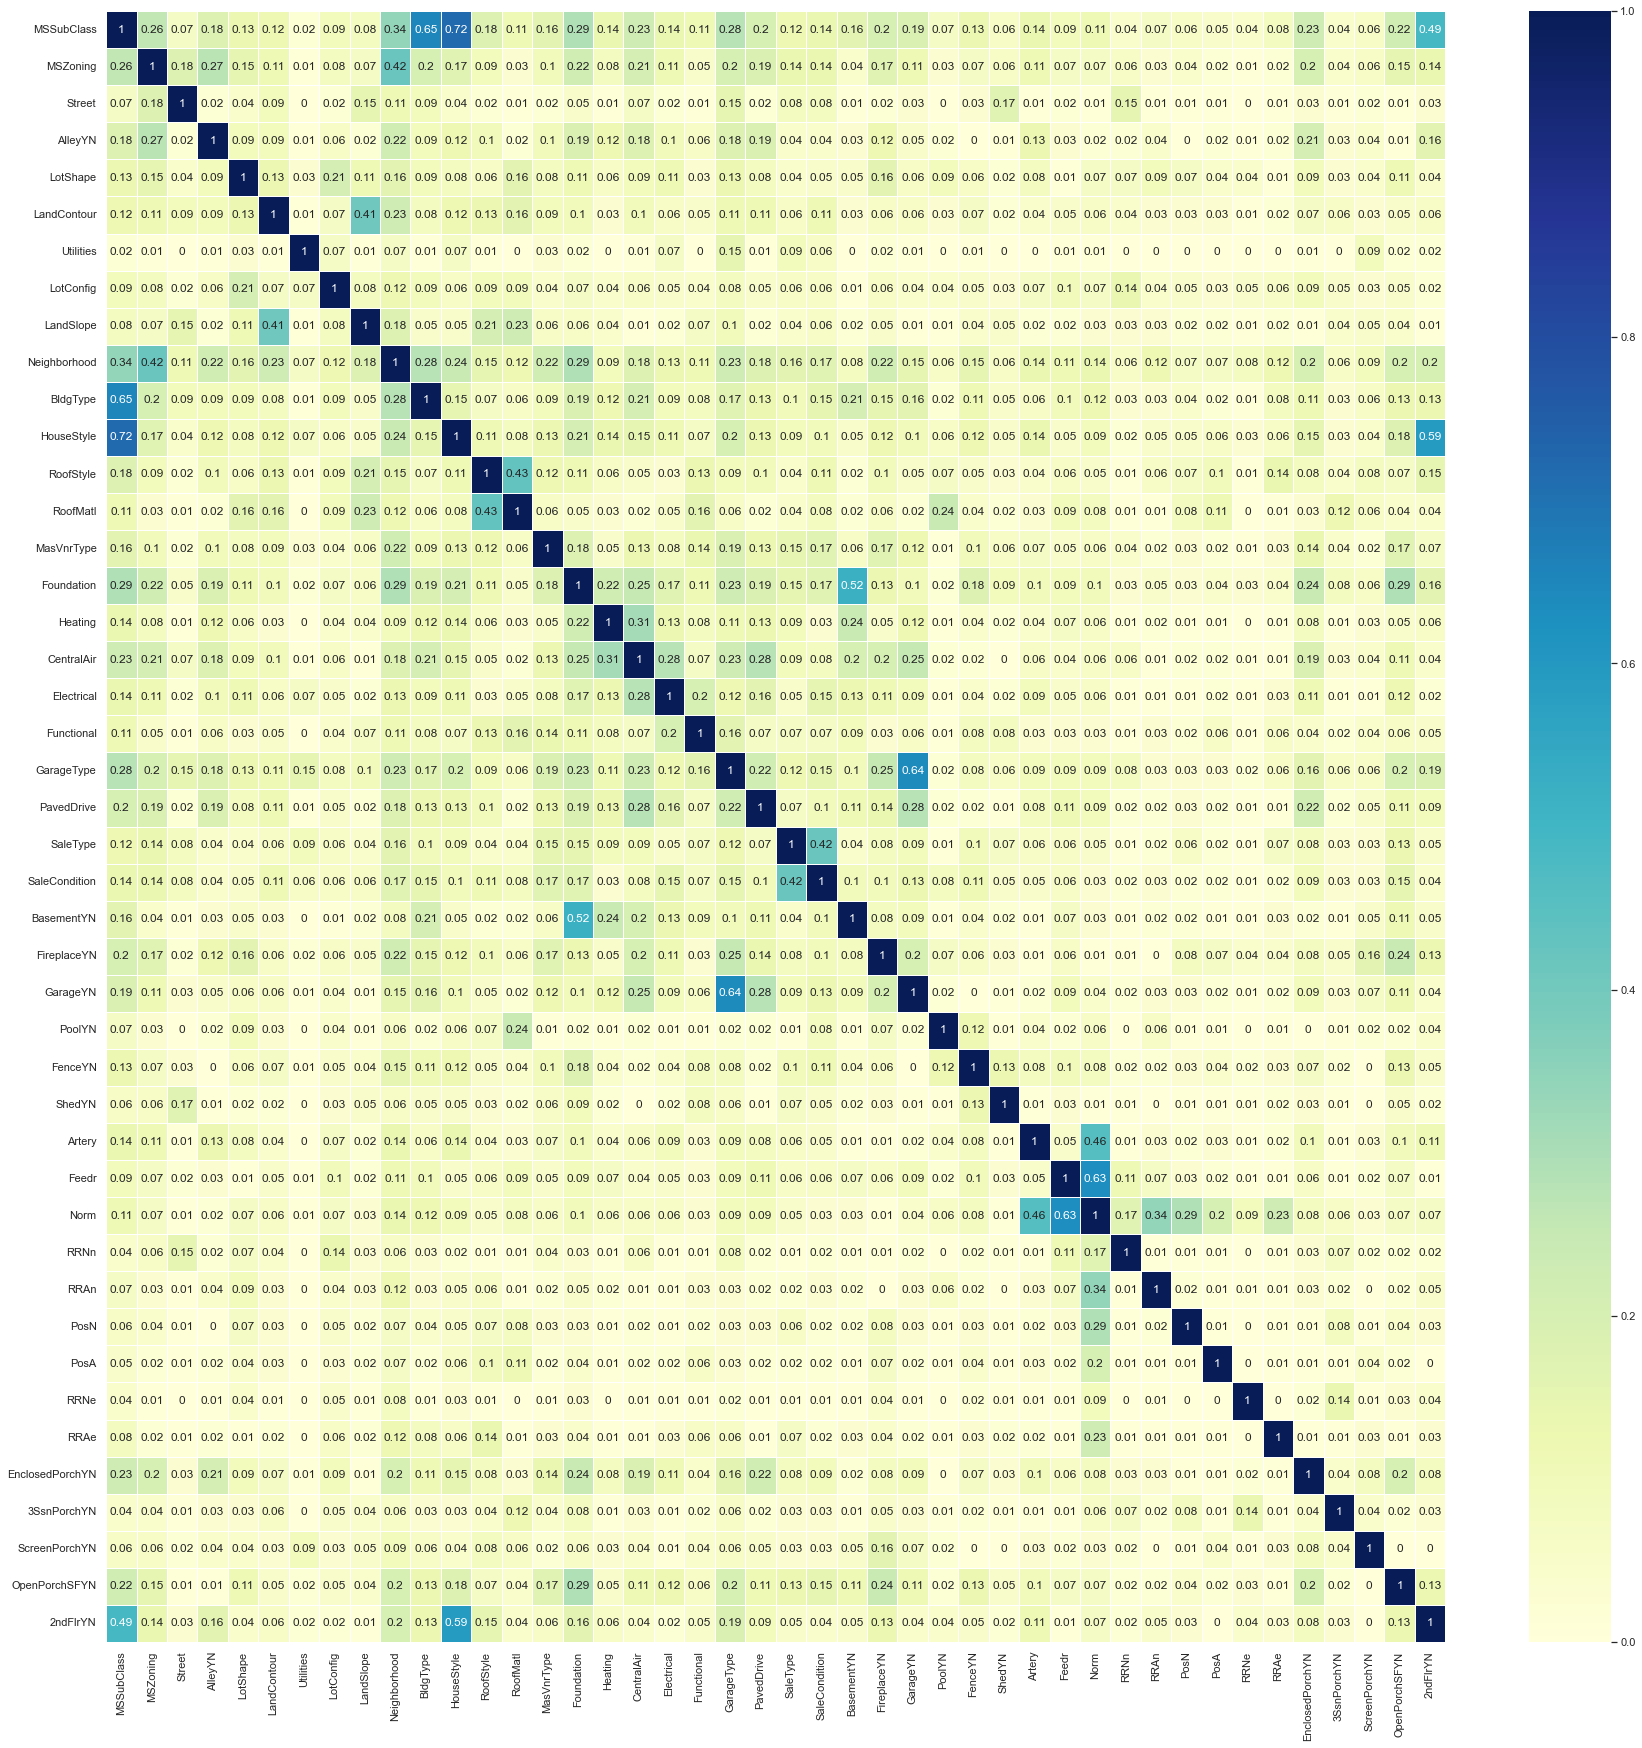

In [49]:
plt.figure(figsize = (30,30))
sns.heatmap(T_czuprowa_table.round(2), cmap="YlGnBu", linecolor="white", linewidth=0.5, vmin= 0, vmax= 1, annot=True);

#### Conclusion:
The MSSubClass variable is strongly correlated with BldgType and HouseStyle, but there is no dependency between these variables, the MSSubClass variable will be removed from the model. The Norm and Feddr variables are also highly correlated, but both came from the initial modification of the Condition variable (proximity to certain places) and correspond to the normal location of the property or near a federal road, so I will not delete either of them. The GarageYN and GarageType variables are strongly correlated - because the GarageType variable contains information whether there is a garage, so this variable will remain. HouseStyle and 2ndFlrYN are dependent, they both inform about the number of floors in some way, so we can remove the variable 2ndFlrYN which contains less information.

#### Wykres zależności między zmiennymi kategorialnymi a zmienną celu

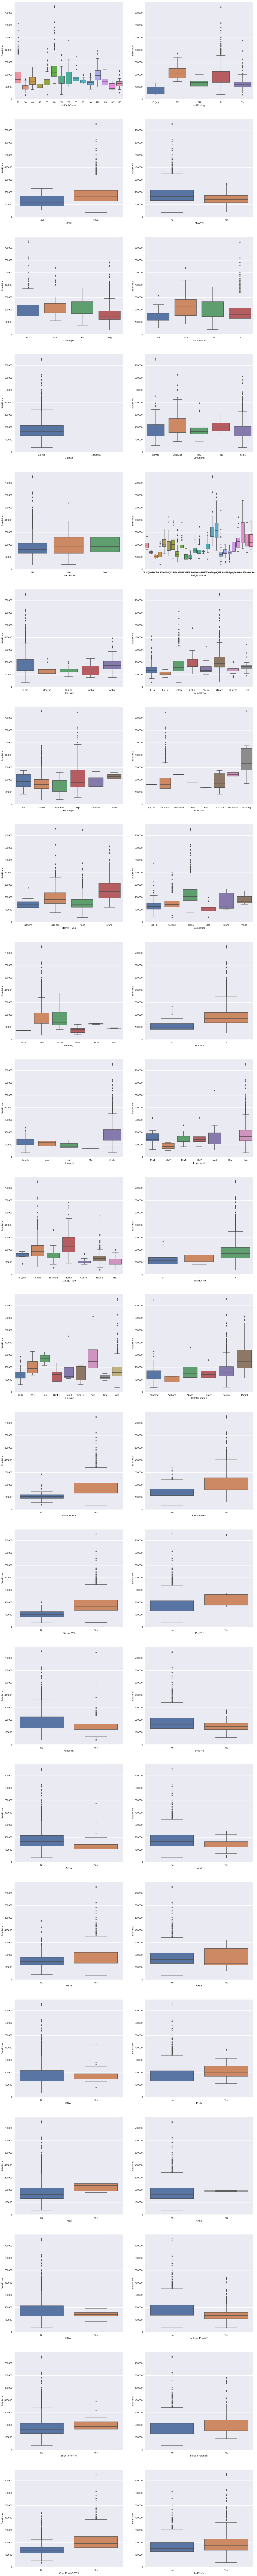

In [50]:
draw_boxplots(df_train, categorical_features, y='SalePrice')

#### Conclusion:
Boxplots indicate that there is a relationship between the categorical variables and the target variable.

### Zmienna celu SALE PRICE

#### Descriptive statistics

In [51]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

#### Histogram

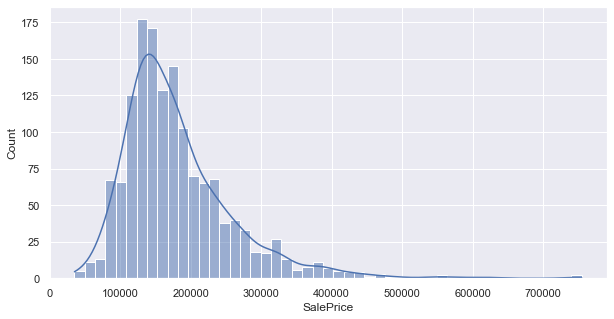

In [52]:
plt.figure(figsize=(10,5))
sns.histplot(df_train, x='SalePrice', kde=True);

#### Boxplot

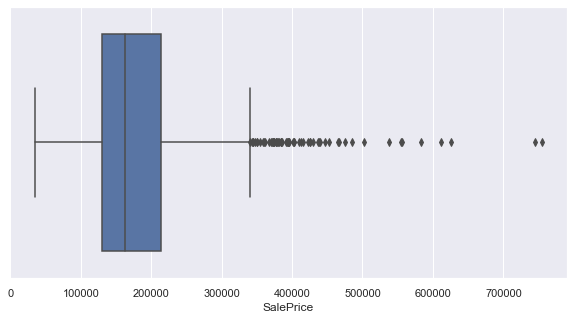

In [53]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df_train, x='SalePrice');

#### Normality test

In [54]:
tests_normal(df_train, ['SalePrice'])

stats_pearson  p_value_pearson  \
SalePrice     610.835911    2.283848e-133   

                                     conclusion_pearson  
SalePrice  The distribution isn't a normal distribution

#### Conclusion:
The 'SalePrice' variable is not normally distributed, the distribution shows right-sided asymmetry.

### MODEL

#### Preparation of training data

In [55]:
df_train = df_train_raw.copy()

In [56]:
X_train = df_train.drop(["SalePrice"],axis=1)
y_train = df_train["SalePrice"]

In [57]:
mapping_function(X_train, mapping_ordinal_variables)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1             60       RL         65.0     8450   Pave   NaN      Reg   
2             20       RL         80.0     9600   Pave   NaN      Reg   
3             60       RL         68.0    11250   Pave   NaN      IR1   
4             70       RL         60.0     9550   Pave   NaN      IR1   
5             60       RL         84.0    14260   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
1456          60       RL         62.0     7917   Pave   NaN      Reg   
1457          20       RL         85.0    13175   Pave   NaN      Reg   
1458          70       RL         66.0     9042   Pave   NaN      Reg   
1459          20       RL         68.0     9717   Pave   NaN      Reg   
1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC  Fence  \
Id                                    ...                                      
1            Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
2            Lvl    AllPub       FR2  ...           0        0    NaN    NaN   
3            Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
4            Lvl    AllPub    Corner  ...           0        0    NaN    NaN   
5            Lvl    AllPub       FR2  ...           0        0    NaN    NaN   
...          ...       ...       ...  ...         ...      ...    ...    ...   
1456         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
1457         Lvl    AllPub    Inside  ...           0        0    NaN  MnPrv   
1458         Lvl    AllPub    Inside  ...           0        0    NaN  GdPrv   
1459         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
1460         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   

     MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
Id                                                                 
1            NaN       0       2    2008        WD         Normal  
2            NaN       0       5    2007        WD         Normal  
3            NaN       0       9    2008        WD         Normal  
4            NaN       0       2    2006        WD        Abnorml  
5            NaN       0      12    2008        WD         Normal  
...          ...     ...     ...     ...       ...            ...  
1456         NaN       0       8    2007        WD         Normal  
1457         NaN       0       2    2010        WD         Normal  
1458        Shed    2500       5    2010        WD         Normal  
1459         NaN       0       4    2010        WD         Normal  
1460         NaN       0       6    2008        WD         Normal  

[1460 rows x 79 columns]

In [58]:
function_new_features(X_train)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1             60       RL         65.0     8450   Pave   NaN      Reg   
2             20       RL         80.0     9600   Pave   NaN      Reg   
3             60       RL         68.0    11250   Pave   NaN      IR1   
4             70       RL         60.0     9550   Pave   NaN      IR1   
5             60       RL         84.0    14260   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
1456          60       RL         62.0     7917   Pave   NaN      Reg   
1457          20       RL         85.0    13175   Pave   NaN      Reg   
1458          70       RL         66.0     9042   Pave   NaN      Reg   
1459          20       RL         68.0     9717   Pave   NaN      Reg   
1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... Exter    Bsmt BsmtBathYN AgeGarage  \
Id                                    ...                                      
1            Lvl    AllPub    Inside  ...   2.5  1.6667        Yes       5.0   
2            Lvl    AllPub       FR2  ...   2.0  2.6667        Yes      31.0   
3            Lvl    AllPub    Inside  ...   2.5  2.0000        Yes       7.0   
4            Lvl    AllPub    Corner  ...   2.0  1.6667        Yes       8.0   
5            Lvl    AllPub       FR2  ...   2.5  2.3333        Yes       8.0   
...          ...       ...       ...  ...   ...     ...        ...       ...   
1456         Lvl    AllPub    Inside  ...   2.0  1.6667         No       8.0   
1457         Lvl    AllPub    Inside  ...   2.0  1.6667        Yes      32.0   
1458         Lvl    AllPub    Inside  ...   3.5  1.6667         No      69.0   
1459         Lvl    AllPub    Inside  ...   2.0  1.6667        Yes      60.0   
1460         Lvl    AllPub    Inside  ...   2.5  1.3333        Yes      43.0   

     Garage OpenPorchSFYN  EnclosedPorchYN  3SsnPorchYN  ScreenPorchYN  \
Id                                                                       
1       2.0           Yes               No           No             No   
2       2.0            No               No           No             No   
3       2.0           Yes               No           No             No   
4       2.5           Yes              Yes           No             No   
5       2.0           Yes               No           No             No   
...     ...           ...              ...          ...            ...   
1456    2.0           Yes               No           No             No   
1457    2.0            No               No           No             No   
1458    2.5           Yes               No           No             No   
1459    2.0            No              Yes           No             No   
1460    2.0           Yes               No           No             No   

      2ndFlrYN  
Id              
1          Yes  
2           No  
3          Yes  
4          Yes  
5          Yes  
...        ...  
1456       Yes  
1457        No  
1458       Yes  
1459        No  
1460        No  

[1460 rows x 107 columns]

#### Preparation of test data

In [59]:
X_test = X_test_raw.copy()

In [60]:
mapping_function(X_test, mapping_ordinal_variables)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1461          20       RH         80.0    11622   Pave   NaN      Reg   
1462          20       RL         81.0    14267   Pave   NaN      IR1   
1463          60       RL         74.0    13830   Pave   NaN      IR1   
1464          60       RL         78.0     9978   Pave   NaN      IR1   
1465         120       RL         43.0     5005   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
2915         160       RM         21.0     1936   Pave   NaN      Reg   
2916         160       RM         21.0     1894   Pave   NaN      Reg   
2917          20       RL        160.0    20000   Pave   NaN      Reg   
2918          85       RL         62.0    10441   Pave   NaN      Reg   
2919          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC  Fence  \
Id                                    ...                                      
1461         Lvl    AllPub    Inside  ...         120        0    NaN  MnPrv   
1462         Lvl    AllPub    Corner  ...           0        0    NaN    NaN   
1463         Lvl    AllPub    Inside  ...           0        0    NaN  MnPrv   
1464         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
1465         HLS    AllPub    Inside  ...         144        0    NaN    NaN   
...          ...       ...       ...  ...         ...      ...    ...    ...   
2915         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
2916         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
2917         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
2918         Lvl    AllPub    Inside  ...           0        0    NaN  MnPrv   
2919         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   

     MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
Id                                                                 
1461         NaN       0       6    2010        WD         Normal  
1462        Gar2   12500       6    2010        WD         Normal  
1463         NaN       0       3    2010        WD         Normal  
1464         NaN       0       6    2010        WD         Normal  
1465         NaN       0       1    2010        WD         Normal  
...          ...     ...     ...     ...       ...            ...  
2915         NaN       0       6    2006        WD         Normal  
2916         NaN       0       4    2006        WD        Abnorml  
2917         NaN       0       9    2006        WD        Abnorml  
2918        Shed     700       7    2006        WD         Normal  
2919         NaN       0      11    2006        WD         Normal  

[1459 rows x 79 columns]

In [61]:
function_new_features(X_test)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1461          20       RH         80.0    11622   Pave   NaN      Reg   
1462          20       RL         81.0    14267   Pave   NaN      IR1   
1463          60       RL         74.0    13830   Pave   NaN      IR1   
1464          60       RL         78.0     9978   Pave   NaN      IR1   
1465         120       RL         43.0     5005   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
2915         160       RM         21.0     1936   Pave   NaN      Reg   
2916         160       RM         21.0     1894   Pave   NaN      Reg   
2917          20       RL        160.0    20000   Pave   NaN      Reg   
2918          85       RL         62.0    10441   Pave   NaN      Reg   
2919          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... Exter    Bsmt BsmtBathYN AgeGarage  \
Id                                    ...                                      
1461         Lvl    AllPub    Inside  ...   2.0  1.3333         No      49.0   
1462         Lvl    AllPub    Corner  ...   2.0  1.3333         No      52.0   
1463         Lvl    AllPub    Inside  ...   2.0  1.6667         No      13.0   
1464         Lvl    AllPub    Inside  ...   2.0  1.3333         No      12.0   
1465         HLS    AllPub    Inside  ...   2.5  1.6667         No      18.0   
...          ...       ...       ...  ...   ...     ...        ...       ...   
2915         Lvl    AllPub    Inside  ...   2.0  1.3333         No       NaN   
2916         Lvl    AllPub    Inside  ...   2.0  1.3333         No      36.0   
2917         Lvl    AllPub    Inside  ...   2.0  1.3333        Yes      46.0   
2918         Lvl    AllPub    Inside  ...   2.0  2.3333        Yes       NaN   
2919         Lvl    AllPub    Inside  ...   2.0  2.3333         No      13.0   

     Garage OpenPorchSFYN  EnclosedPorchYN  3SsnPorchYN  ScreenPorchYN  \
Id                                                                       
1461    2.0            No               No           No            Yes   
1462    2.0           Yes               No           No             No   
1463    2.0           Yes               No           No             No   
1464    2.0           Yes               No           No             No   
1465    2.0           Yes               No           No            Yes   
...     ...           ...              ...          ...            ...   
2915    0.5            No               No           No             No   
2916    2.0           Yes               No           No             No   
2917    2.0            No               No           No             No   
2918    0.5           Yes               No           No             No   
2919    2.0           Yes               No           No             No   

      2ndFlrYN  
Id              
1461        No  
1462        No  
1463       Yes  
1464       Yes  
1465        No  
...        ...  
2915       Yes  
2916       Yes  
2917        No  
2918        No  
2919       Yes  

[1459 rows x 107 columns]

#### List of variables in the model and their types

In [62]:
# zmienne numeryczne ciągłe
continuous_features = ['LotArea', 'LotFrontage', 'AgeHouse', '1stFlrSF', 'GrLivArea', 'GarageArea']

# zmienne numeryczne dyskretne
discrete_features = ['FullBath', 'HalfBath', 'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces', 'GarageCars']

# zmienne porządkowe
ordinal_features = ['Overall', 'Exter', 'Bsmt','HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'Garage']

# zmienne kategoryczne
categorical_features = ['MSZoning', 'Street', 'AlleyYN', 'LotShape', 'LandContour', 'Utilities',
                        'LotConfig', 'LandSlope', 'Neighborhood', 'BldgType', 'HouseStyle', 'RoofStyle', 
                       'RoofMatl', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 
                       'Functional', 'GarageType', 'PavedDrive', 'SaleType', 'SaleCondition', 'BasementYN', 
                       'FireplaceYN', 'PoolYN', 'FenceYN', 'ShedYN', 'Artery', 'Feedr', 'Norm', 
                       'RRNn', 'RRAn', 'PosN', 'PosA', 'RRNe', 'RRAe',  'EnclosedPorchYN', '3SsnPorchYN','ScreenPorchYN', 
                       'OpenPorchSFYN']

In [63]:
#change of data type for categorical variables
for i in categorical_features:
    X_train[i] = X_train[i].astype('category')
    X_test[i] = X_test[i].astype('category')

#### Creating a pipeline for models

In [64]:
continuous_pipe = Pipeline([
    
    ("simple_imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
    
])

discrete_pipe = Pipeline([
    ("simple_imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
ordinal_pipe = Pipeline([
    ("simple_imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])


categorical_pipe = Pipeline([
    ("simple_imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot_encoder", OneHotEncoder(handle_unknown='ignore'))
])



In [65]:
preprocessor = ColumnTransformer([
        ("continuous", continuous_pipe, continuous_features),
        ("discrete", discrete_pipe, discrete_features),
        ("categorical", categorical_pipe, categorical_features),
        ("ordinal", ordinal_pipe, ordinal_features)
        
    ], remainder="drop"
)
preprocessor

ColumnTransformer(transformers=[('continuous',
                                 Pipeline(steps=[('simple_imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['LotArea', 'LotFrontage', 'AgeHouse',
                                  '1stFlrSF', 'GrLivArea', 'GarageArea']),
                                ('discrete',
                                 Pipeline(steps=[('simple_imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['FullBath', 'HalfBath'...
                                  'CentralAir', 'Electrical', 'Functional',
                                  'GarageType', 'PavedDrive', 'SaleType',
                                  'SaleCondition', 'BasementYN', 'FireplaceYN',
                                  'PoolYN', 'FenceYN', 'ShedYN', 'Artery',
                                  'Feedr', ...]),
                                ('ordinal',
                                 Pipeline(steps=[('simple_imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Overall', 'Exter', 'Bsmt', 'HeatingQC',
                                  'KitchenQual', 'FireplaceQu', 'GarageFinish',
                                  'Garage'])])

#### Rigde

In [66]:
pipe1 = Pipeline([
    ("preprocessor", preprocessor),
    ("model", Ridge())
])
pipe1

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LotArea', 'LotFrontage',
                                                   'AgeHouse', '1stFlrSF',
                                                   'GrLivArea', 'GarageArea']),
                                                 ('discrete',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardSc...
                                                   'Functional', 'GarageType',
                                                   'PavedDrive', 'SaleType',
                                                   'SaleCondition',
                                                   'BasementYN', 'FireplaceYN',
                                                   'PoolYN', 'FenceYN',
                                                   'ShedYN', 'Artery', 'Feedr', ...]),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Overall', 'Exter', 'Bsmt',
                                                   'HeatingQC', 'KitchenQual',
                                                   'FireplaceQu',
                                                   'GarageFinish',
                                                   'Garage'])])),
                ('model', Ridge())])

In [67]:
pipe1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LotArea', 'LotFrontage',
                                                   'AgeHouse', '1stFlrSF',
                                                   'GrLivArea', 'GarageArea']),
                                                 ('discrete',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardSc...
                                                   'Functional', 'GarageType',
                                                   'PavedDrive', 'SaleType',
                                                   'SaleCondition',
                                                   'BasementYN', 'FireplaceYN',
                                                   'PoolYN', 'FenceYN',
                                                   'ShedYN', 'Artery', 'Feedr', ...]),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Overall', 'Exter', 'Bsmt',
                                                   'HeatingQC', 'KitchenQual',
                                                   'FireplaceQu',
                                                   'GarageFinish',
                                                   'Garage'])])),
                ('model', Ridge())])

In [69]:
# looking for the best model
grid1 = {"model__alpha": np.linspace(0,50,101),
        "model__solver": ['auto', 'svd', 'lsqr', 'saga']
       }

optimizer1 = GridSearchCV(pipe1, grid1, 
                         scoring="neg_mean_absolute_error", 
                         cv=10, 
                         n_jobs=-1)
optimizer1.fit(X_train, y_train)



GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('continuous',
                                                                         Pipeline(steps=[('simple_imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['LotArea',
                                                                          'LotFrontage',
                                                                          'AgeHouse',
                                                                          '1stFlrSF',
                                                                          'GrLivArea',
                                                                          'GarageArea']),
                                                                        ('discrete',
                                                                         Pipeline(steps=[('simple_imputer',
                                                                                          SimpleImputer(strategy='m...
       16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
       22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
       27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5,
       33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. ,
       38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5,
       44. , 44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. ,
       49.5, 50. ]),
                         'model__solver': ['auto', 'svd', 'lsqr', 'saga']},
             scoring='neg_mean_absolute_error')

In [70]:
# parametrs of the best model
best_prarams1 = optimizer1.best_params_
best_prarams1

{'model__alpha': 24.5, 'model__solver': 'lsqr'}

In [71]:
# MAE best for model for CrossValidation
best_score1 = -optimizer1.best_score_
best_score1

19498.256684034146

In [72]:
# MAE for training data
MAE1_train = mean_absolute_error(y_train, optimizer1.best_estimator_.predict(X_train))
MAE1_train

18099.866652096043

In [73]:
# MAE for test data
MAE1_test = mean_absolute_error(y_test, optimizer1.best_estimator_.predict(X_test))
MAE1_test

54960.23036614506

#### Lasso

In [74]:
pipe2 = Pipeline([
    ("preprocessor", preprocessor),
    ("model", Lasso())
])
pipe2

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LotArea', 'LotFrontage',
                                                   'AgeHouse', '1stFlrSF',
                                                   'GrLivArea', 'GarageArea']),
                                                 ('discrete',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardSc...
                                                   'Functional', 'GarageType',
                                                   'PavedDrive', 'SaleType',
                                                   'SaleCondition',
                                                   'BasementYN', 'FireplaceYN',
                                                   'PoolYN', 'FenceYN',
                                                   'ShedYN', 'Artery', 'Feedr', ...]),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Overall', 'Exter', 'Bsmt',
                                                   'HeatingQC', 'KitchenQual',
                                                   'FireplaceQu',
                                                   'GarageFinish',
                                                   'Garage'])])),
                ('model', Lasso())])

In [75]:
pipe2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LotArea', 'LotFrontage',
                                                   'AgeHouse', '1stFlrSF',
                                                   'GrLivArea', 'GarageArea']),
                                                 ('discrete',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardSc...
                                                   'Functional', 'GarageType',
                                                   'PavedDrive', 'SaleType',
                                                   'SaleCondition',
                                                   'BasementYN', 'FireplaceYN',
                                                   'PoolYN', 'FenceYN',
                                                   'ShedYN', 'Artery', 'Feedr', ...]),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Overall', 'Exter', 'Bsmt',
                                                   'HeatingQC', 'KitchenQual',
                                                   'FireplaceQu',
                                                   'GarageFinish',
                                                   'Garage'])])),
                ('model', Lasso())])

In [76]:
# looking for the best model
grid2 = {"model__alpha": np.linspace(0,100,101)}

optimizer2 = GridSearchCV(pipe2, grid2, 
                         scoring="neg_mean_absolute_error", 
                         cv=10, 
                         n_jobs=-1)

optimizer2.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('continuous',
                                                                         Pipeline(steps=[('simple_imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['LotArea',
                                                                          'LotFrontage',
                                                                          'AgeHouse',
                                                                          '1stFlrSF',
                                                                          'GrLivArea',
                                                                          'GarageArea']),
                                                                        ('discrete',
                                                                         Pipeline(steps=[('simple_imputer',
                                                                                          SimpleImputer(strategy='m...
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100.])},
             scoring='neg_mean_absolute_error')

In [77]:
# parameters of the best model
best_prarams2 = optimizer2.best_params_
best_prarams2

{'model__alpha': 58.0}

In [78]:
# MAE best for model for CrossValidation
best_score2 = -optimizer2.best_score_
best_score2

19264.610637158115

In [79]:
# MAE for training data
MAE2_train = mean_absolute_error(y_train, optimizer2.best_estimator_.predict(X_train))
MAE2_train

17476.463936086104

In [80]:
# MAE for test data
MAE2_test = mean_absolute_error(y_test, optimizer2.best_estimator_.predict(X_test))
MAE2_test

55540.77738788994

#### Elastic - Net

In [81]:
pipe3 = Pipeline([
    ("preprocessor", preprocessor),
    ("model", ElasticNet())
])
pipe3

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LotArea', 'LotFrontage',
                                                   'AgeHouse', '1stFlrSF',
                                                   'GrLivArea', 'GarageArea']),
                                                 ('discrete',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardSc...
                                                   'Functional', 'GarageType',
                                                   'PavedDrive', 'SaleType',
                                                   'SaleCondition',
                                                   'BasementYN', 'FireplaceYN',
                                                   'PoolYN', 'FenceYN',
                                                   'ShedYN', 'Artery', 'Feedr', ...]),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Overall', 'Exter', 'Bsmt',
                                                   'HeatingQC', 'KitchenQual',
                                                   'FireplaceQu',
                                                   'GarageFinish',
                                                   'Garage'])])),
                ('model', ElasticNet())])

In [82]:
pipe3.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LotArea', 'LotFrontage',
                                                   'AgeHouse', '1stFlrSF',
                                                   'GrLivArea', 'GarageArea']),
                                                 ('discrete',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardSc...
                                                   'Functional', 'GarageType',
                                                   'PavedDrive', 'SaleType',
                                                   'SaleCondition',
                                                   'BasementYN', 'FireplaceYN',
                                                   'PoolYN', 'FenceYN',
                                                   'ShedYN', 'Artery', 'Feedr', ...]),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Overall', 'Exter', 'Bsmt',
                                                   'HeatingQC', 'KitchenQual',
                                                   'FireplaceQu',
                                                   'GarageFinish',
                                                   'Garage'])])),
                ('model', ElasticNet())])

In [84]:
# looking for the best model
grid3 = {"model__alpha": np.linspace(0.01,100,50),
         "model__l1_ratio": np.linspace(0.01,1,50) }

optimizer3 = GridSearchCV(pipe3, grid3, 
                         scoring="neg_mean_absolute_error", 
                         cv=10, 
                         n_jobs=-1)

optimizer3.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('continuous',
                                                                         Pipeline(steps=[('simple_imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['LotArea',
                                                                          'LotFrontage',
                                                                          'AgeHouse',
                                                                          '1stFlrSF',
                                                                          'GrLivArea',
                                                                          'GarageArea']),
                                                                        ('discrete',
                                                                         Pipeline(steps=[('simple_imputer',
                                                                                          SimpleImputer(strategy='m...
       0.41408163, 0.43428571, 0.4544898 , 0.47469388, 0.49489796,
       0.51510204, 0.53530612, 0.5555102 , 0.57571429, 0.59591837,
       0.61612245, 0.63632653, 0.65653061, 0.67673469, 0.69693878,
       0.71714286, 0.73734694, 0.75755102, 0.7777551 , 0.79795918,
       0.81816327, 0.83836735, 0.85857143, 0.87877551, 0.89897959,
       0.91918367, 0.93938776, 0.95959184, 0.97979592, 1.        ])},
             scoring='neg_mean_absolute_error')

In [85]:
# parameters of the best model
best_prarams3 = optimizer3.best_params_
best_prarams3

{'model__alpha': 57.14714285714285, 'model__l1_ratio': 1.0}

In [86]:
# MAE best for model for CrossValidation
best_score3 = -optimizer3.best_score_
best_score3

19264.664909667117

In [87]:
# MAE for training data
MAE3_train = mean_absolute_error(y_train, optimizer3.best_estimator_.predict(X_train))
MAE3_train

17471.143565210117

In [88]:
# MAE for test data
MAE3_test = mean_absolute_error(y_test, optimizer3.best_estimator_.predict(X_test))
MAE3_test

55550.51506601322

#### Linear Regression

In [89]:
pipe4 = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])
pipe4

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LotArea', 'LotFrontage',
                                                   'AgeHouse', '1stFlrSF',
                                                   'GrLivArea', 'GarageArea']),
                                                 ('discrete',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardSc...
                                                   'PavedDrive', 'SaleType',
                                                   'SaleCondition',
                                                   'BasementYN', 'FireplaceYN',
                                                   'PoolYN', 'FenceYN',
                                                   'ShedYN', 'Artery', 'Feedr', ...]),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Overall', 'Exter', 'Bsmt',
                                                   'HeatingQC', 'KitchenQual',
                                                   'FireplaceQu',
                                                   'GarageFinish',
                                                   'Garage'])])),
                ('model', LinearRegression())])

In [90]:
pipe4.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LotArea', 'LotFrontage',
                                                   'AgeHouse', '1stFlrSF',
                                                   'GrLivArea', 'GarageArea']),
                                                 ('discrete',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardSc...
                                                   'PavedDrive', 'SaleType',
                                                   'SaleCondition',
                                                   'BasementYN', 'FireplaceYN',
                                                   'PoolYN', 'FenceYN',
                                                   'ShedYN', 'Artery', 'Feedr', ...]),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Overall', 'Exter', 'Bsmt',
                                                   'HeatingQC', 'KitchenQual',
                                                   'FireplaceQu',
                                                   'GarageFinish',
                                                   'Garage'])])),
                ('model', LinearRegression())])

In [91]:
# MAE for training data
MAE4_train = mean_absolute_error(y_train, pipe4.predict(X_train))
MAE4_train

17055.642979452055

In [92]:
# MAE for test data
MAE4_test = mean_absolute_error(y_test, pipe4.predict(X_test))
MAE4_test

56418.51595543675

#### XGBooster

In [93]:
pipe5 = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBRegressor())
])
pipe5

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LotArea', 'LotFrontage',
                                                   'AgeHouse', '1stFlrSF',
                                                   'GrLivArea', 'GarageArea']),
                                                 ('discrete',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardSc...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [94]:
pipe5.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LotArea', 'LotFrontage',
                                                   'AgeHouse', '1stFlrSF',
                                                   'GrLivArea', 'GarageArea']),
                                                 ('discrete',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardSc...
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=6, max_leaves=0,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, predictor='auto',
                              random_state=0, ...))])

In [97]:
# looking for the best model
grid5 = {"model__n_estimators":  [5,10,15,20],
         "model__max_depth": [2, 5, 10],
         "model__eta": [0.01, 0.1, 0.3],
         "model__subsample" : [0, 0.5, 1],
         "model__colsample_bytree": [0, 0.5, 1]
                }

optimizer5 = GridSearchCV(pipe5, grid5, 
                         scoring="neg_mean_absolute_error", 
                         cv=10, 
                         n_jobs=-1)

optimizer5.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('continuous',
                                                                         Pipeline(steps=[('simple_imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['LotArea',
                                                                          'LotFrontage',
                                                                          'AgeHouse',
                                                                          '1stFlrSF',
                                                                          'GrLivArea',
                                                                          'GarageArea']),
                                                                        ('discrete',
                                                                         Pipeline(steps=[('simple_imputer',
                                                                                          SimpleImputer(strategy='m...
                                                     min_child_weight=1,
                                                     missing=nan,
                                                     monotone_constraints='()',
                                                     n_estimators=100, n_jobs=0,
                                                     num_parallel_tree=1,
                                                     predictor='auto',
                                                     random_state=0, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0, 0.5, 1],
                         'model__eta': [0.01, 0.1, 0.3],
                         'model__max_depth': [2, 5, 10],
                         'model__n_estimators': [5, 10, 15, 20],
                         'model__subsample': [0, 0.5, 1]},
             scoring='neg_mean_absolute_error')

In [98]:
# parameters of the best model
best_prarams5 = optimizer5.best_params_
best_prarams5

{'model__colsample_bytree': 1,
 'model__eta': 0.01,
 'model__max_depth': 5,
 'model__n_estimators': 20,
 'model__subsample': 1}

In [99]:
# MAE best for model for CrossValidation
best_score5 = -optimizer5.best_score_
best_score5

18250.21584171661

In [100]:
# MAE for training data
MAE5_train = mean_absolute_error(y_train, optimizer5.best_estimator_.predict(X_train))
MAE5_train

9727.709110124144

In [101]:
# MAE for test data
MAE5_test = mean_absolute_error(y_test, optimizer5.best_estimator_.predict(X_test))
MAE5_test

54470.23957233473

#### Decision Tree Regressor

In [102]:
pipe6 = Pipeline([
    ("preprocessor", preprocessor),
    ("model", DecisionTreeRegressor())
])
pipe6

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LotArea', 'LotFrontage',
                                                   'AgeHouse', '1stFlrSF',
                                                   'GrLivArea', 'GarageArea']),
                                                 ('discrete',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardSc...
                                                   'PavedDrive', 'SaleType',
                                                   'SaleCondition',
                                                   'BasementYN', 'FireplaceYN',
                                                   'PoolYN', 'FenceYN',
                                                   'ShedYN', 'Artery', 'Feedr', ...]),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Overall', 'Exter', 'Bsmt',
                                                   'HeatingQC', 'KitchenQual',
                                                   'FireplaceQu',
                                                   'GarageFinish',
                                                   'Garage'])])),
                ('model', DecisionTreeRegressor())])

In [103]:
pipe6.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LotArea', 'LotFrontage',
                                                   'AgeHouse', '1stFlrSF',
                                                   'GrLivArea', 'GarageArea']),
                                                 ('discrete',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardSc...
                                                   'PavedDrive', 'SaleType',
                                                   'SaleCondition',
                                                   'BasementYN', 'FireplaceYN',
                                                   'PoolYN', 'FenceYN',
                                                   'ShedYN', 'Artery', 'Feedr', ...]),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Overall', 'Exter', 'Bsmt',
                                                   'HeatingQC', 'KitchenQual',
                                                   'FireplaceQu',
                                                   'GarageFinish',
                                                   'Garage'])])),
                ('model', DecisionTreeRegressor())])

In [104]:
# looking for the best model
grid6 = {"model__max_depth": [2, 5, 10 ,15 ,20 ,25 ,30 ,35 ,None], 
        "model__min_samples_split": [2,3,4,5,10], 
        "model__min_samples_leaf": [1, 2, 3, 4, 5],
         "model__splitter": ["best", "random"]}
                

optimizer6 = GridSearchCV(pipe6, grid6, 
                         scoring="neg_mean_absolute_error", 
                         cv=10, 
                         n_jobs=-1)

optimizer6.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('continuous',
                                                                         Pipeline(steps=[('simple_imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['LotArea',
                                                                          'LotFrontage',
                                                                          'AgeHouse',
                                                                          '1stFlrSF',
                                                                          'GrLivArea',
                                                                          'GarageArea']),
                                                                        ('discrete',
                                                                         Pipeline(steps=[('simple_imputer',
                                                                                          SimpleImputer(strategy='m...
                                                                         ['Overall',
                                                                          'Exter',
                                                                          'Bsmt',
                                                                          'HeatingQC',
                                                                          'KitchenQual',
                                                                          'FireplaceQu',
                                                                          'GarageFinish',
                                                                          'Garage'])])),
                                       ('model', DecisionTreeRegressor())]),
             n_jobs=-1,
             param_grid={'model__max_depth': [2, 5, 10, 15, 20, 25, 30, 35,
                                              None],
                         'model__min_samples_leaf': [1, 2, 3, 4, 5],
                         'model__min_samples_split': [2, 3, 4, 5, 10],
                         'model__splitter': ['best', 'random']},
             scoring='neg_mean_absolute_error')

In [105]:
# parameters of the best model
best_prarams6 = optimizer6.best_params_
best_prarams6

{'model__max_depth': 20,
 'model__min_samples_leaf': 5,
 'model__min_samples_split': 10,
 'model__splitter': 'best'}

In [106]:
# MAE best for model for CrossValidation
best_score6 = -optimizer6.best_score_
best_score6

25250.94141226353

In [107]:
# MAE for training data
MAE6_train = mean_absolute_error(y_train, optimizer6.best_estimator_.predict(X_train))
MAE6_train

13271.677881061101

In [108]:
# MAE for test data
MAE6_test = mean_absolute_error(y_test, optimizer6.best_estimator_.predict(X_test))
MAE6_test

55590.75959184772

#### Random Forest Regressor

In [109]:
pipe7 = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(20))
])
pipe7

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LotArea', 'LotFrontage',
                                                   'AgeHouse', '1stFlrSF',
                                                   'GrLivArea', 'GarageArea']),
                                                 ('discrete',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardSc...
                                                   'PavedDrive', 'SaleType',
                                                   'SaleCondition',
                                                   'BasementYN', 'FireplaceYN',
                                                   'PoolYN', 'FenceYN',
                                                   'ShedYN', 'Artery', 'Feedr', ...]),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Overall', 'Exter', 'Bsmt',
                                                   'HeatingQC', 'KitchenQual',
                                                   'FireplaceQu',
                                                   'GarageFinish',
                                                   'Garage'])])),
                ('model', RandomForestRegressor(n_estimators=20))])

In [110]:
pipe7.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LotArea', 'LotFrontage',
                                                   'AgeHouse', '1stFlrSF',
                                                   'GrLivArea', 'GarageArea']),
                                                 ('discrete',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardSc...
                                                   'PavedDrive', 'SaleType',
                                                   'SaleCondition',
                                                   'BasementYN', 'FireplaceYN',
                                                   'PoolYN', 'FenceYN',
                                                   'ShedYN', 'Artery', 'Feedr', ...]),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Overall', 'Exter', 'Bsmt',
                                                   'HeatingQC', 'KitchenQual',
                                                   'FireplaceQu',
                                                   'GarageFinish',
                                                   'Garage'])])),
                ('model', RandomForestRegressor(n_estimators=20))])

In [111]:
# looking for the best model
grid7 = {"model__max_depth": np.linspace(5,35,7).tolist()+[None],
         "model__min_samples_split": [2, 5, 10, 15, 20], 
         "model__min_samples_leaf": [1, 2, 3, 4, 5], 
         "model__n_estimators": [5, 10, 20, 30, 50, 100] 
    }
                

optimizer7 = GridSearchCV(pipe7, grid7, 
                         scoring="neg_mean_absolute_error", 
                         cv=10, 
                         n_jobs=-1)

optimizer7.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('continuous',
                                                                         Pipeline(steps=[('simple_imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['LotArea',
                                                                          'LotFrontage',
                                                                          'AgeHouse',
                                                                          '1stFlrSF',
                                                                          'GrLivArea',
                                                                          'GarageArea']),
                                                                        ('discrete',
                                                                         Pipeline(steps=[('simple_imputer',
                                                                                          SimpleImputer(strategy='m...
                                                                          'HeatingQC',
                                                                          'KitchenQual',
                                                                          'FireplaceQu',
                                                                          'GarageFinish',
                                                                          'Garage'])])),
                                       ('model',
                                        RandomForestRegressor(n_estimators=20))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [5.0, 10.0, 15.0, 20.0, 25.0, 30.0,
                                              35.0, None],
                         'model__min_samples_leaf': [1, 2, 3, 4, 5],
                         'model__min_samples_split': [2, 5, 10, 15, 20],
                         'model__n_estimators': [5, 10, 20, 30, 50, 100]},
             scoring='neg_mean_absolute_error')

In [112]:
# parameters of the best model
best_prarams7 = optimizer7.best_params_
best_prarams7

{'model__max_depth': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

In [113]:
# MAE best for model for CrossValidation
best_score7 = -optimizer7.best_score_
best_score7

17802.34213731246

In [114]:
# MAE for training data
MAE7_train = mean_absolute_error(y_train, optimizer7.best_estimator_.predict(X_train))
MAE7_train

6718.0815913242

In [115]:
# MAE for test data
MAE7_test = mean_absolute_error(y_test, optimizer7.best_estimator_.predict(X_test))
MAE7_test

52650.05902648699

#### Comparison of results

In [125]:
y_test_mean = y_test.mean()[0]
y_train_mean = y_train.mean()

df_result = {'Rigde': [best_prarams1, best_score1, MAE1_train, MAE1_train/y_train_mean, MAE1_test, MAE1_test / y_test_mean],
             'Lasso': [best_prarams2, best_score2, MAE2_train, MAE2_train/y_train_mean, MAE2_test, MAE2_test / y_test_mean],
             'ElasticNet': [best_prarams3, best_score3, MAE3_train, MAE3_train/y_train_mean, MAE3_test, MAE3_test / y_test_mean],
             'LinearRegresion': [np.nan, np.nan, MAE4_train, MAE4_train/y_train_mean, MAE4_test, MAE4_test / y_test_mean],
             'XGBRegressor': [best_prarams5, best_score5, MAE5_train, MAE5_train/y_train_mean, MAE5_test, MAE5_test / y_test_mean],
             'DecisionTreeRegressor': [best_prarams6, best_score6, MAE6_train, MAE6_train/y_train_mean, MAE6_test, MAE6_test / y_test_mean],
             'RandomForestRegressor': [best_prarams7, best_score7, MAE7_train, MAE7_train/y_train_mean, MAE7_test, MAE7_test / y_test_mean]
            }
pd.DataFrame(data=df_result, index=['best_params', 'best_score', 'MAE_train', '%MAE_train', 'MAE_test', '%MAE_test']).T

best_params  \
Rigde                    {'model__alpha': 24.5, 'model__solver': 'lsqr'}   
Lasso                                             {'model__alpha': 58.0}   
ElasticNet             {'model__alpha': 57.14714285714285, 'model__l1...   
LinearRegresion                                                      NaN   
XGBRegressor           {'model__colsample_bytree': 1, 'model__eta': 0...   
DecisionTreeRegressor  {'model__max_depth': 20, 'model__min_samples_l...   
RandomForestRegressor  {'model__max_depth': None, 'model__min_samples...   

                         best_score     MAE_train %MAE_train      MAE_test  \
Rigde                  19498.256684  18099.866652   0.100043  54960.230366   
Lasso                  19264.610637  17476.463936   0.096597  55540.777388   
ElasticNet              19264.66491  17471.143565   0.096568  55550.515066   
LinearRegresion                 NaN  17055.642979   0.094271  56418.515955   
XGBRegressor           18250.215842    9727.70911   0.053768  54470.239572   
DecisionTreeRegressor  25250.941412  13271.677881   0.073356  55590.759592   
RandomForestRegressor  17802.342137   6718.081591   0.037133  52650.059026   

                      %MAE_test  
Rigde                  0.306725  
Lasso                  0.309965  
ElasticNet              0.31002  
LinearRegresion        0.314864  
XGBRegressor           0.303991  
DecisionTreeRegressor  0.310244  
RandomForestRegressor  0.293833

#### Conclusion:
All models give very similar results - MAE on the test set ranges from 52.6 thousand to 56.5 thousand, which oscillates around 30% of the average 'SalePrice' value on the test set. Among the examined models, the Random Forest Regresor has the lowest value of the mean absolute error metric, which means that this model describes the real estate sale price in the best way.